## Instalasi & Import Library

In [ ]:
# Mengunduh model Glove untuk Bahasa Inggris
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

# Mengunduh model FastText untuk Bahasa Jawa
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.jv.300.vec.gz
!gunzip -q cc.jv.300.vec.gz



--2026-01-08 09:25:58--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2026-01-08 09:25:59--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2026-01-08 09:25:59--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import pickle
import time
import json
import sys
from google.colab import drive
from collections import Counter

from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, Concatenate, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    CSVLogger
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K


!pip install sacrebleu -q
import sacrebleu
!pip install nltk -q
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from tqdm import tqdm

# 1. PENYIAPAN DATA
print("--- 1. Memuat dan Menyiapkan Data ---")
drive.mount('/content/drive', force_remount=True)

EN_FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/dataset_skripsi/dataset-english.en"
JV_FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/dataset_skripsi/dataset-javanese.jv"
MODEL_SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/model_skripsi_glove_fasttext_attention_LSTM_4/"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

try:
    with open(EN_FILE_PATH, 'r', encoding='utf-8') as f:
        english_sentences = f.read().splitlines()
    with open(JV_FILE_PATH, 'r', encoding='utf-8') as f:
        javanese_sentences = f.read().splitlines()
except FileNotFoundError as e:
    print(f"Error: File tidak ditemukan. Pastikan path file sudah benar.")
    raise e
df = pd.DataFrame({'english': english_sentences, 'javanese': javanese_sentences})
print("Dataset berhasil dimuat.\n")


--- 1. Memuat dan Menyiapkan Data ---
Mounted at /content/drive
Dataset berhasil dimuat.



## EDA (Exploratory Data Analysis)

In [ ]:
print(df.info())
print(df.head())
print(df.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10587 entries, 0 to 10586
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   english   10587 non-null  object
 1   javanese  10587 non-null  object
dtypes: object(2)
memory usage: 165.6+ KB
None
                                             english  \
0              Do you agree with his opinion or not?   
1                         Try to be a little polite.   
2                            The flag is already up.   
3           I fell asleep while studying at my desk.   
4  We can't distinguish him from his younger sibl...   

                                          javanese  
0            Kowe sarujuk apa ora marang panemune?  
1                         Kowe jajal sopan sithik.  
2                           Genderane wis munggah.  
3         Aku katuron nalika sinau ana ing mejaku.  
4  Awakdhewe ora bisa mbedakake dheke karo adhine.  
                                    en

In [ ]:
print("Jumlah data:", len(df))
print("Duplikasi:", df.duplicated().sum())
print("Missing values:\n", df.isnull().sum())

Jumlah data: 10587
Duplikasi: 180
Missing values:
 english     0
javanese    0
dtype: int64


In [ ]:
# 1. Identifikasi baris yang duplikat
mask_duplikat = df.duplicated(keep='first')

# 2. Ambil data yang terdeteksi sebagai duplikat
data_yang_akan_dihapus = df[mask_duplikat]

# 3. Tampilkan hasilnya
print(f"Ditemukan {len(data_yang_akan_dihapus)} baris duplikat yang akan dihapus.")
print("\n--- Contoh Data yang Dihapus (5 Teratas) ---")
print(data_yang_akan_dihapus.head())

df_bersih = df.drop_duplicates()

print(f"\nSisa data bersih: {len(df_bersih)}")

Ditemukan 180 baris duplikat yang akan dihapus.

--- Contoh Data yang Dihapus (5 Teratas) ---
                                                english  \
561                             Be careful on the road.   
991                       Surrender the results to God.   
1283  I am hungry, have not had food since the morni...   
1284                            Don't cut young trees.    
1285  The fish isn't supposed to be thrown away. It ...   

                                               javanese  
561                                  Ati-ati ing dalan.  
991                        Asile pasrahna marang Gusti.  
1283          Aku ngelih, durung mangan kawit mau isuk.  
1284                     Aja negori wit sing isih enom.  
1285  Iwake dhonge aja diguwak, isa dienggo pakan ku...  

Sisa data bersih: 10407


In [ ]:
df['eng_len'] = df['english'].apply(lambda x: len(x.split()))
df['jv_len'] = df['javanese'].apply(lambda x: len(x.split()))

print(df[['eng_len', 'jv_len']].describe())

            eng_len        jv_len
count  10587.000000  10587.000000
mean       6.824596      5.666289
std        2.598836      2.222721
min        0.000000      0.000000
25%        5.000000      4.000000
50%        6.000000      5.000000
75%        8.000000      7.000000
max       29.000000     23.000000


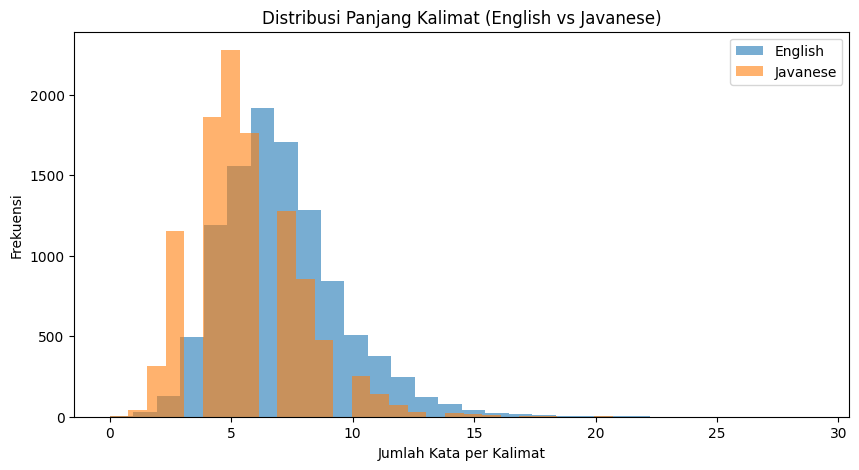

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(df['eng_len'], bins=30, alpha=0.6, label='English')
plt.hist(df['jv_len'], bins=30, alpha=0.6, label='Javanese')
plt.xlabel("Jumlah Kata per Kalimat")
plt.ylabel("Frekuensi")
plt.legend()
plt.title("Distribusi Panjang Kalimat (English vs Javanese)")
plt.show()


In [ ]:
eng_vocab = set(" ".join(df['english']).split())
jv_vocab = set(" ".join(df['javanese']).split())

print("Jumlah kata unik English :", len(eng_vocab))
print("Jumlah kata unik Javanese:", len(jv_vocab))


Jumlah kata unik English : 9566
Jumlah kata unik Javanese: 9401


In [ ]:
def analyze_vocab(text_series, lang_name):
    all_words = " ".join(text_series.astype(str)).split()
    vocab_count = Counter(all_words)
    total_vocab = len(vocab_count)
    singletons = sum(1 for count in vocab_count.values() if count == 1)

    print(f"--- Analisis Kosa Kata {lang_name} ---")
    print(f"Total kata unik (Vocab Size): {total_vocab}")
    print(f"Kata yang hanya muncul 1 kali: {singletons} ({singletons/total_vocab:.2%})")
    print(f"10 Kata paling umum: {vocab_count.most_common(10)}\n")

analyze_vocab(df['english'], "Inggris")
analyze_vocab(df['javanese'], "Jawa")

--- Analisis Kosa Kata Inggris ---
Total kata unik (Vocab Size): 9566
Kata yang hanya muncul 1 kali: 5439 (56.86%)
10 Kata paling umum: [('to', 2843), ('I', 2357), ('the', 2112), ('Tom', 1850), ('a', 1594), ('is', 1404), ('do', 1150), ('you', 1034), ('was', 817), ('of', 795)]

--- Analisis Kosa Kata Jawa ---
Total kata unik (Vocab Size): 9401
Kata yang hanya muncul 1 kali: 5346 (56.87%)
10 Kata paling umum: [('Aku', 2214), ('Tom', 1845), ('ora', 1742), ('sing', 1418), ('ing', 1152), ('bakal', 813), ('kanggo', 754), ('Dheweke', 638), ('Apa', 585), ('bisa', 575)]



ANALISIS IMBALANCE DATA - TERJEMAHAN INGGRIS-JAWA

1. DISTRIBUSI PANJANG KALIMAT
----------------------------------------------------------------------
Statistik Panjang Kalimat Bahasa Inggris:
count    10587.000000
mean         6.824596
std          2.598836
min          0.000000
25%          5.000000
50%          6.000000
75%          8.000000
max         29.000000
Name: en_length, dtype: float64

Statistik Panjang Kalimat Bahasa Jawa:
count    10587.000000
mean         5.666289
std          2.222721
min          0.000000
25%          4.000000
50%          5.000000
75%          7.000000
max         23.000000
Name: jv_length, dtype: float64


/tmp/ipython-input-994157992.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot([df['en_length'], df['jv_length']], labels=['English', 'Javanese'])


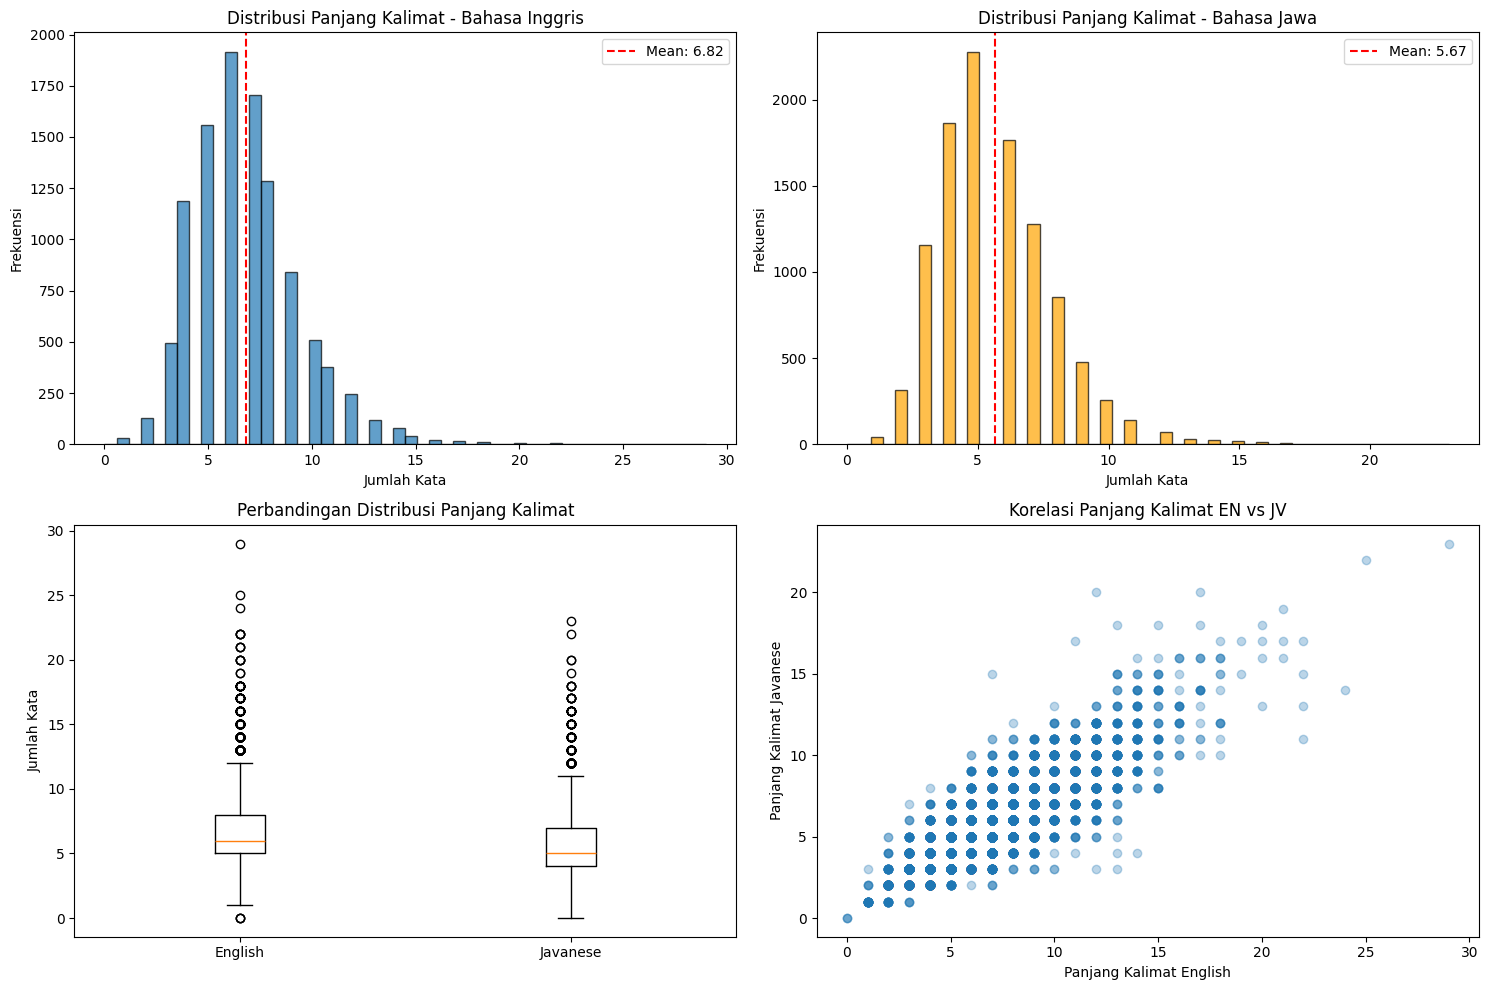


2. DETEKSI OUTLIERS
----------------------------------------------------------------------
Jumlah outliers Bahasa Inggris: 310 (2.93%)
Jumlah outliers Bahasa Jawa: 170 (1.61%)

3. DISTRIBUSI KOSAKATA
----------------------------------------------------------------------
Ukuran Vocabulary Bahasa Inggris: 9,019
Ukuran Vocabulary Bahasa Jawa: 8,633
Total kata Bahasa Inggris: 72,252
Total kata Bahasa Jawa: 59,989

Top 20 Kata Tersering - Bahasa Inggris:
  to: 2865
  the: 2782
  i: 2357
  tom: 1850
  a: 1700
  you: 1471
  is: 1457
  do: 1297
  that: 832
  was: 830
  of: 800
  in: 783
  he: 663
  that.: 636
  it: 594
  be: 586
  my: 570
  for: 568
  have: 558
  and: 507

Top 20 Kata Tersering - Bahasa Jawa:
  aku: 2760
  ora: 1904
  tom: 1845
  sing: 1457
  ing: 1193
  dheweke: 1077
  sampeyan: 905
  apa: 822
  bakal: 816
  kanggo: 774
  bisa: 622
  kudu: 575
  yen: 536
  wis: 518
  nindakake: 507
  iku: 475
  lan: 464
  ana: 448
  karo: 430
  wong: 427

4. ANALISIS IMBALANCE FREKUENSI KATA

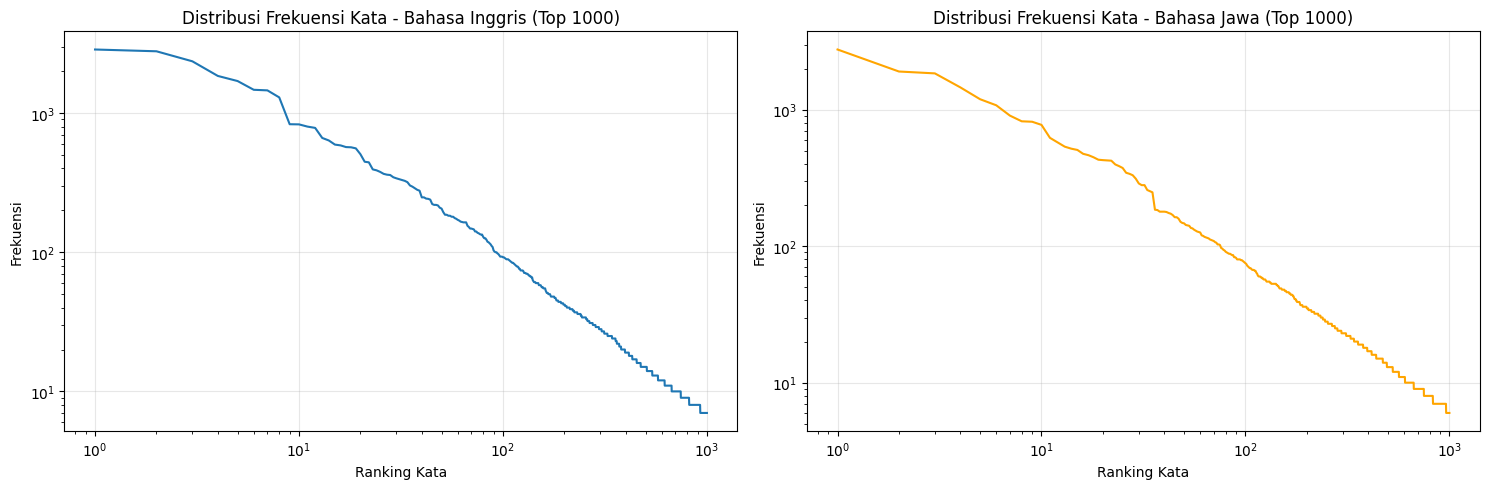


5. RASIO PANJANG KALIMAT
----------------------------------------------------------------------
Statistik Rasio Panjang (EN/JV):
count    10584.000000
mean         1.243240
std          0.306904
min          0.333333
25%          1.000000
50%          1.200000
75%          1.400000
max          4.333333
Name: length_ratio, dtype: float64


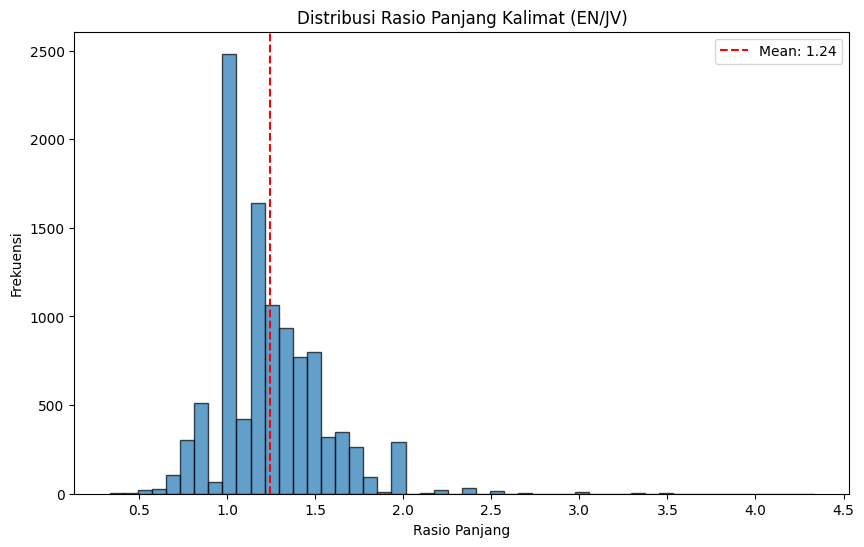


6. DETEKSI DATA DUPLIKAT
----------------------------------------------------------------------
Kalimat duplikat Bahasa Inggris: 243 (2.30%)
Kalimat duplikat Bahasa Jawa: 695 (6.56%)
Pasangan kalimat duplikat: 180 (1.70%)

7. DETEKSI KALIMAT BERMASALAH
----------------------------------------------------------------------
Kalimat kosong Bahasa Inggris: 3
Kalimat kosong Bahasa Jawa: 3

Menyimpan hasil analisis...
Analisis selesai! File tersimpan sebagai: /content/drive/MyDrive/Colab Notebooks/model_skripsi_glove_fasttext_attention_LSTM_4/analisis_dataset.csv


In [ ]:
# Asumsikan df sudah dimuat dengan kolom 'english' dan 'javanese'

def analyze_data_imbalance(df):
    """
    Fungsi untuk menganalisis berbagai aspek imbalance data pada dataset terjemahan
    """

    print("="*70)
    print("ANALISIS IMBALANCE DATA - TERJEMAHAN INGGRIS-JAWA")
    print("="*70)

    # 1. DISTRIBUSI PANJANG KALIMAT
    print("\n1. DISTRIBUSI PANJANG KALIMAT")
    print("-"*70)

    df['en_length'] = df['english'].apply(lambda x: len(x.split()))
    df['jv_length'] = df['javanese'].apply(lambda x: len(x.split()))

    print(f"Statistik Panjang Kalimat Bahasa Inggris:")
    print(df['en_length'].describe())
    print(f"\nStatistik Panjang Kalimat Bahasa Jawa:")
    print(df['jv_length'].describe())

    # Visualisasi distribusi panjang
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Histogram Bahasa Inggris
    axes[0, 0].hist(df['en_length'], bins=50, edgecolor='black', alpha=0.7)
    axes[0, 0].set_title('Distribusi Panjang Kalimat - Bahasa Inggris')
    axes[0, 0].set_xlabel('Jumlah Kata')
    axes[0, 0].set_ylabel('Frekuensi')
    axes[0, 0].axvline(df['en_length'].mean(), color='red', linestyle='--',
                       label=f'Mean: {df["en_length"].mean():.2f}')
    axes[0, 0].legend()

    # Histogram Bahasa Jawa
    axes[0, 1].hist(df['jv_length'], bins=50, edgecolor='black', alpha=0.7, color='orange')
    axes[0, 1].set_title('Distribusi Panjang Kalimat - Bahasa Jawa')
    axes[0, 1].set_xlabel('Jumlah Kata')
    axes[0, 1].set_ylabel('Frekuensi')
    axes[0, 1].axvline(df['jv_length'].mean(), color='red', linestyle='--',
                       label=f'Mean: {df["jv_length"].mean():.2f}')
    axes[0, 1].legend()

    # Box plot perbandingan
    axes[1, 0].boxplot([df['en_length'], df['jv_length']], labels=['English', 'Javanese'])
    axes[1, 0].set_title('Perbandingan Distribusi Panjang Kalimat')
    axes[1, 0].set_ylabel('Jumlah Kata')

    # Scatter plot korelasi panjang
    axes[1, 1].scatter(df['en_length'], df['jv_length'], alpha=0.3)
    axes[1, 1].set_title('Korelasi Panjang Kalimat EN vs JV')
    axes[1, 1].set_xlabel('Panjang Kalimat English')
    axes[1, 1].set_ylabel('Panjang Kalimat Javanese')

    plt.tight_layout()
    plt.savefig('distribusi_panjang_kalimat.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. DETEKSI OUTLIERS PANJANG KALIMAT
    print("\n2. DETEKSI OUTLIERS")
    print("-"*70)

    # Menggunakan IQR method
    Q1_en = df['en_length'].quantile(0.25)
    Q3_en = df['en_length'].quantile(0.75)
    IQR_en = Q3_en - Q1_en
    outliers_en = df[(df['en_length'] < Q1_en - 1.5*IQR_en) |
                     (df['en_length'] > Q3_en + 1.5*IQR_en)]

    Q1_jv = df['jv_length'].quantile(0.25)
    Q3_jv = df['jv_length'].quantile(0.75)
    IQR_jv = Q3_jv - Q1_jv
    outliers_jv = df[(df['jv_length'] < Q1_jv - 1.5*IQR_jv) |
                     (df['jv_length'] > Q3_jv + 1.5*IQR_jv)]

    print(f"Jumlah outliers Bahasa Inggris: {len(outliers_en)} ({len(outliers_en)/len(df)*100:.2f}%)")
    print(f"Jumlah outliers Bahasa Jawa: {len(outliers_jv)} ({len(outliers_jv)/len(df)*100:.2f}%)")

    # 3. DISTRIBUSI KOSAKATA (VOCABULARY)
    print("\n3. DISTRIBUSI KOSAKATA")
    print("-"*70)

    # Tokenisasi sederhana
    en_words = ' '.join(df['english'].values).lower().split()
    jv_words = ' '.join(df['javanese'].values).lower().split()

    en_vocab = Counter(en_words)
    jv_vocab = Counter(jv_words)

    print(f"Ukuran Vocabulary Bahasa Inggris: {len(en_vocab):,}")
    print(f"Ukuran Vocabulary Bahasa Jawa: {len(jv_vocab):,}")
    print(f"Total kata Bahasa Inggris: {len(en_words):,}")
    print(f"Total kata Bahasa Jawa: {len(jv_words):,}")

    # Top 20 kata paling sering
    print(f"\nTop 20 Kata Tersering - Bahasa Inggris:")
    for word, count in en_vocab.most_common(20):
        print(f"  {word}: {count}")

    print(f"\nTop 20 Kata Tersering - Bahasa Jawa:")
    for word, count in jv_vocab.most_common(20):
        print(f"  {word}: {count}")

    # 4. IMBALANCE FREKUENSI KATA
    print("\n4. ANALISIS IMBALANCE FREKUENSI KATA")
    print("-"*70)

    # Menghitung persentase kata yang muncul hanya sekali
    en_hapax = sum(1 for count in en_vocab.values() if count == 1)
    jv_hapax = sum(1 for count in jv_vocab.values() if count == 1)

    print(f"Kata yang hanya muncul 1x (hapax legomena) - EN: {en_hapax} ({en_hapax/len(en_vocab)*100:.2f}%)")
    print(f"Kata yang hanya muncul 1x (hapax legomena) - JV: {jv_hapax} ({jv_hapax/len(jv_vocab)*100:.2f}%)")

    # Visualisasi distribusi frekuensi kata
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    en_freq = sorted(en_vocab.values(), reverse=True)
    jv_freq = sorted(jv_vocab.values(), reverse=True)

    axes[0].plot(range(1, min(1000, len(en_freq))+1), en_freq[:1000])
    axes[0].set_title('Distribusi Frekuensi Kata - Bahasa Inggris (Top 1000)')
    axes[0].set_xlabel('Ranking Kata')
    axes[0].set_ylabel('Frekuensi')
    axes[0].set_yscale('log')
    axes[0].set_xscale('log')
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(range(1, min(1000, len(jv_freq))+1), jv_freq[:1000], color='orange')
    axes[1].set_title('Distribusi Frekuensi Kata - Bahasa Jawa (Top 1000)')
    axes[1].set_xlabel('Ranking Kata')
    axes[1].set_ylabel('Frekuensi')
    axes[1].set_yscale('log')
    axes[1].set_xscale('log')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('distribusi_frekuensi_kata.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 5. RASIO PANJANG KALIMAT
    print("\n5. RASIO PANJANG KALIMAT")
    print("-"*70)

    df['length_ratio'] = df['en_length'] / df['jv_length']
    df['length_ratio'] = df['length_ratio'].replace([np.inf, -np.inf], np.nan)

    print(f"Statistik Rasio Panjang (EN/JV):")
    print(df['length_ratio'].describe())

    plt.figure(figsize=(10, 6))
    plt.hist(df['length_ratio'].dropna(), bins=50, edgecolor='black', alpha=0.7)
    plt.title('Distribusi Rasio Panjang Kalimat (EN/JV)')
    plt.xlabel('Rasio Panjang')
    plt.ylabel('Frekuensi')
    plt.axvline(df['length_ratio'].mean(), color='red', linestyle='--',
                label=f'Mean: {df["length_ratio"].mean():.2f}')
    plt.legend()
    plt.savefig('rasio_panjang_kalimat.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 6. DETEKSI DATA DUPLIKAT
    print("\n6. DETEKSI DATA DUPLIKAT")
    print("-"*70)

    en_duplicates = df['english'].duplicated().sum()
    jv_duplicates = df['javanese'].duplicated().sum()
    pair_duplicates = df.duplicated(subset=['english', 'javanese']).sum()

    print(f"Kalimat duplikat Bahasa Inggris: {en_duplicates} ({en_duplicates/len(df)*100:.2f}%)")
    print(f"Kalimat duplikat Bahasa Jawa: {jv_duplicates} ({jv_duplicates/len(df)*100:.2f}%)")
    print(f"Pasangan kalimat duplikat: {pair_duplicates} ({pair_duplicates/len(df)*100:.2f}%)")

    # 7. DETEKSI KALIMAT KOSONG ATAU SANGAT PENDEK
    print("\n7. DETEKSI KALIMAT BERMASALAH")
    print("-"*70)

    empty_en = df[df['english'].str.strip() == '']
    empty_jv = df[df['javanese'].str.strip() == '']

    print(f"Kalimat kosong Bahasa Inggris: {len(empty_en)}")
    print(f"Kalimat kosong Bahasa Jawa: {len(empty_jv)}")

    return df

# Jalankan analisis
df_analyzed = analyze_data_imbalance(df)

# Simpan hasil analisis
print("\nMenyimpan hasil analisis...")

SAVE_PATH = os.path.join(MODEL_SAVE_PATH, "analisis_dataset.csv")

df_analyzed[['english', 'javanese', 'en_length', 'jv_length', 'length_ratio']].to_csv(
    SAVE_PATH,
    index=False
)

print(f"Analisis selesai! File tersimpan sebagai: {SAVE_PATH}")


## Preprocessing

In [ ]:
# 2. PRA-PEMROSESAN DATA (PREPROCESSING) - VERSI DIPERBAIKI
print("--- 2. Memulai Pra-pemrosesan Data (Enhanced Version) ---")

# BAGIAN 1: DEFINISI FUNGSI PREPROCESSING
def preprocess_english(text):
    """Preprocessing untuk Bahasa Inggris"""
    text = str(text).lower().strip()
    # Hapus multiple spaces dulu
    text = re.sub(r'\s+', ' ', text)
    # Spasi untuk punctuation (tanpa menambah spasi berlebih)
    text = re.sub(r"([?.!,¿'])", r" \1 ", text)
    # Hapus karakter selain huruf unicode, spasi, dan tanda baca
    text = re.sub(r"[^a-zA-Z0-9?.!,¿'\s-]", "", text)
    # Normalisasi spasi berlebih yang mungkin muncul
    text = re.sub(r'\s+', ' ', text)

    return text.strip()

def preprocess_javanese(text):
    """Preprocessing untuk Bahasa Jawa (dengan handling khusus)"""
    text = str(text).lower().strip()
    # Hapus multiple spaces dulu
    text = re.sub(r'\s+', ' ', text)
    # Spasi untuk punctuation
    text = re.sub(r"([?.!,¿'])", r" \1 ", text)
    # IZINKAN huruf unicode seperti è é dh èk ñ (\p{M} untuk combining marks)
    text = re.sub(r"[^a-zA-Z0-9áéèê?.!,¿'\s-]", "", text)
    # Normalisasi spasi berlebih
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# BAGIAN 2: CLEANING DATA AWAL (SEBELUM SPLIT)\
print(f"Jumlah data awal: {len(df)}")

# Buat kolom preprocessing sementara
df['temp_eng'] = df['english'].apply(preprocess_english)
df['temp_jv'] = df['javanese'].apply(preprocess_javanese)

# Hitung panjang kata
df['eng_len'] = df['temp_eng'].apply(lambda x: len(x.split()))
df['jv_len'] = df['temp_jv'].apply(lambda x: len(x.split()))

# FILTER 1: KALIMAT KOSONG
print("\n[Filter 1] Menghapus kalimat kosong...")
before = len(df)
df_clean = df[
    (df['temp_eng'].str.strip() != '') &
    (df['temp_jv'].str.strip() != '') &
    (df['eng_len'] > 0) &
    (df['jv_len'] > 0)
].copy()
print(f"  Dihapus: {before - len(df_clean)} baris")

# FILTER 2: OUTLIERS PANJANG (>35 kata)
print("\n[Filter 2] Menghapus outliers panjang (>35 kata)...")
before = len(df_clean)
df_clean = df_clean[
    (df_clean['eng_len'] <= 35) &
    (df_clean['jv_len'] <= 35)
].copy()
print(f"  Dihapus: {before - len(df_clean)} baris (2.82% EN, 1.57% JV dari analisis)")

# FILTER 3: OUTLIERS RASIO PANJANG
# Rasio ekstrem menandakan mistranslation atau noise
print("\n[Filter 3] Menghapus outliers rasio panjang...")
df_clean['ratio'] = df_clean['jv_len'] / df_clean['eng_len']
before = len(df_clean)

# Gunakan IQR method untuk deteksi outlier yang lebih robust
Q1 = df_clean['ratio'].quantile(0.25)
Q3 = df_clean['ratio'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean = df_clean[
    (df_clean['ratio'] >= lower_bound) &
    (df_clean['ratio'] <= upper_bound)
].copy()
print(f"  Batas rasio: {lower_bound:.2f} - {upper_bound:.2f}")
print(f"  Dihapus: {before - len(df_clean)} baris")

# FILTER 4: HAPUS DUPLIKAT PASANGAN
# Pasangan duplikat tidak menambah informasi baru untuk model
print("\n[Filter 4] Menghapus duplikat pasangan kalimat...")
before = len(df_clean)
df_clean = df_clean.drop_duplicates(subset=['temp_eng', 'temp_jv'], keep='first')
print(f"  Dihapus: {before - len(df_clean)} baris")

# RINGKASAN CLEANING
print("\n" + "="*70)
print(f"RINGKASAN CLEANING:")
print(f"  Data awal        : {len(df):,}")
print(f"  Data bersih      : {len(df_clean):,}")
print(f"  Data dibuang     : {len(df) - len(df_clean):,} ({(len(df) - len(df_clean))/len(df)*100:.2f}%)")
print("="*70 + "\n")

# Kembalikan ke variabel df dan hapus kolom temp
df = df_clean[['english', 'javanese']].copy()

# BAGIAN 3: SPLIT DATA (Train/Val/Test)
print("Split data menjadi train/val/test...")

# Stratified split berdasarkan panjang kalimat untuk representasi merata
# Buat kategori panjang untuk stratifikasi
df['length_category'] = pd.cut(
    df['english'].apply(lambda x: len(preprocess_english(x).split())),
    bins=[0, 5, 10, 15, 100],
    labels=['short', 'medium', 'long', 'very_long']
)

# Split dengan stratifikasi
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['length_category']
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['length_category']
)

# Hapus kolom stratifikasi
train_df = train_df.drop(columns=['length_category']).reset_index(drop=True)
val_df = val_df.drop(columns=['length_category']).reset_index(drop=True)
test_df = test_df.drop(columns=['length_category']).reset_index(drop=True)

print(f"Train : {len(train_df):,} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Val   : {len(val_df):,} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test  : {len(test_df):,} ({len(test_df)/len(df)*100:.1f}%)\n")


# BAGIAN 4: PREPROCESSING FINAL SETIAP SPLIT
print("Melakukan preprocessing final...")

# English (tanpa token khusus)
train_df["english_processed"] = train_df["english"].apply(preprocess_english)
val_df["english_processed"] = val_df["english"].apply(preprocess_english)
test_df["english_processed"] = test_df["english"].apply(preprocess_english)

# Javanese (dengan <start> dan <end>)
train_df["javanese_processed"] = train_df["javanese"].apply(
    lambda s: f"<start> {preprocess_javanese(s)} <end>"
)
val_df["javanese_processed"] = val_df["javanese"].apply(
    lambda s: f"<start> {preprocess_javanese(s)} <end>"
)
test_df["javanese_processed"] = test_df["javanese"].apply(
    lambda s: f"<start> {preprocess_javanese(s)} <end>"
)

print("Contoh preprocessing:")
print("EN (raw)   :", train_df['english'].iloc[0])
print("EN (clean) :", train_df['english_processed'].iloc[0])
print("JV (raw)   :", train_df['javanese'].iloc[0])
print("JV (clean) :", train_df['javanese_processed'].iloc[0], "\n")


# BAGIAN 5: TOKENIZER (DENGAN OPTIMASI)
print("Membangun tokenizer...")

# Limit ke 10000
VOCAB_LIMIT = 10000

# English Tokenizer
eng_tokenizer = Tokenizer(
    num_words=VOCAB_LIMIT,
    filters='',
    oov_token='<unk>',
    lower=False
)
eng_tokenizer.fit_on_texts(train_df['english_processed'])

# Javanese Tokenizer
jv_tokenizer = Tokenizer(
    num_words=VOCAB_LIMIT,
    filters='',
    oov_token='<unk>',
    lower=False
)
jv_tokenizer.fit_on_texts(train_df['javanese_processed'])

# Hitung vocab size aktual
eng_vocab_size = min(len(eng_tokenizer.word_index) + 1, VOCAB_LIMIT)
jv_vocab_size = min(len(jv_tokenizer.word_index) + 1, VOCAB_LIMIT)

print(f"Vocab English  : {eng_vocab_size:,} (dari {len(eng_tokenizer.word_index):,} unique)")
print(f"Vocab Javanese : {jv_vocab_size:,} (dari {len(jv_tokenizer.word_index):,} unique)")

# Hitung coverage (berapa % kata yang ter-cover dengan limit vocab)
def calculate_coverage(tokenizer, texts, vocab_limit):
    all_words = []
    for text in texts:
        all_words.extend(text.split())

    covered = sum(1 for word in all_words
                  if word in tokenizer.word_index
                  and tokenizer.word_index[word] < vocab_limit)

    return (covered / len(all_words)) * 100 if all_words else 0

eng_coverage = calculate_coverage(eng_tokenizer, train_df['english_processed'], VOCAB_LIMIT)
jv_coverage = calculate_coverage(jv_tokenizer, train_df['javanese_processed'], VOCAB_LIMIT)

print(f"Coverage EN    : {eng_coverage:.2f}%")
print(f"Coverage JV    : {jv_coverage:.2f}%\n")


# BAGIAN 6: TOKENISASI & PADDING
print("Tokenisasi sequences...")

# Tokenisasi
eng_sequences_train = eng_tokenizer.texts_to_sequences(train_df['english_processed'])
jv_sequences_train = jv_tokenizer.texts_to_sequences(train_df['javanese_processed'])

eng_sequences_val = eng_tokenizer.texts_to_sequences(val_df['english_processed'])
jv_sequences_val = jv_tokenizer.texts_to_sequences(val_df['javanese_processed'])

eng_sequences_test = eng_tokenizer.texts_to_sequences(test_df['english_processed'])
jv_sequences_test = jv_tokenizer.texts_to_sequences(test_df['javanese_processed'])

# Hitung max length dari train set
max_len_eng = max(len(s) for s in eng_sequences_train)
max_len_jv = max(len(s) for s in jv_sequences_train)

print(f"Max length EN  : {max_len_eng}")
print(f"Max length JV  : {max_len_jv}\n")

# Padding
print("Padding sequences...")
eng_padded_train = pad_sequences(eng_sequences_train, maxlen=max_len_eng, padding='post')
jv_padded_train = pad_sequences(jv_sequences_train, maxlen=max_len_jv, padding='post')

eng_padded_val = pad_sequences(eng_sequences_val, maxlen=max_len_eng, padding='post')
jv_padded_val = pad_sequences(jv_sequences_val, maxlen=max_len_jv, padding='post')

eng_padded_test = pad_sequences(eng_sequences_test, maxlen=max_len_eng, padding='post')
jv_padded_test = pad_sequences(jv_sequences_test, maxlen=max_len_jv, padding='post')


# BAGIAN 7: PERSIAPAN DATA UNTUK MODEL (Teacher Forcing)
print("Menyiapkan data untuk model...")

# Encoder input: full padded English
X_train = eng_padded_train
X_val = eng_padded_val
X_test = eng_padded_test

# Decoder input: Javanese tanpa <end> token
# Decoder output: Javanese tanpa <start> token
y_train_in = jv_padded_train[:, :-1]
y_train_out = jv_padded_train[:, 1:]

y_val_in = jv_padded_val[:, :-1]
y_val_out = jv_padded_val[:, 1:]

y_test_in = jv_padded_test[:, :-1]
y_test_out = jv_padded_test[:, 1:]


# BAGIAN 8: RINGKASAN FINAL
print("\n" + "="*70)
print("RINGKASAN DATA PREPROCESSING")
print("="*70)
print(f"Dataset:")
print(f"  Train : {X_train.shape}")
print(f"  Val   : {X_val.shape}")
print(f"  Test  : {X_test.shape}")
print(f"\nEncoder Input (English):")
print(f"  Shape : {X_train.shape}")
print(f"  Vocab : {eng_vocab_size:,}")
print(f"\nDecoder Input (Javanese - with <start>):")
print(f"  Shape : {y_train_in.shape}")
print(f"  Vocab : {jv_vocab_size:,}")
print(f"\nDecoder Output (Javanese - with <end>):")
print(f"  Shape : {y_train_out.shape}")
print("="*70)

# Verifikasi data tidak mengandung sequence kosong
print(f"\nVerifikasi Quality:")
print(f"  Zero-length sequences EN: {sum(1 for s in eng_sequences_train if len(s) == 0)}")
print(f"  Zero-length sequences JV: {sum(1 for s in jv_sequences_train if len(s) == 0)}")

print("\n--- Pra-pemrosesan selesai (Enhanced) ---\n")


# BAGIAN 9: SIMPAN TOKENIZER & METADATA
print("Menyimpan tokenizer dan metadata...")

# Simpan tokenizer untuk inference nanti
with open(os.path.join(MODEL_SAVE_PATH, 'eng_tokenizer.pkl'), 'wb') as f:
    pickle.dump(eng_tokenizer, f)

with open(os.path.join(MODEL_SAVE_PATH, 'jv_tokenizer.pkl'), 'wb') as f:
    pickle.dump(jv_tokenizer, f)

# Simpan metadata preprocessing
metadata = {
    'eng_vocab_size': eng_vocab_size,
    'jv_vocab_size': jv_vocab_size,
    'max_len_eng': max_len_eng,
    'max_len_jv': max_len_jv,
    'vocab_limit': VOCAB_LIMIT,
    'train_size': len(train_df),
    'val_size': len(val_df),
    'test_size': len(test_df),
    'eng_coverage': eng_coverage,
    'jv_coverage': jv_coverage
}

with open(os.path.join(MODEL_SAVE_PATH, 'preprocessing_metadata.pkl'), 'wb') as f:
    pickle.dump(metadata, f)

print(f"Tokenizer dan metadata tersimpan di: {MODEL_SAVE_PATH}")

--- 2. Memulai Pra-pemrosesan Data (Enhanced Version) ---
Jumlah data awal: 10587

[Filter 1] Menghapus kalimat kosong...
  Dihapus: 3 baris

[Filter 2] Menghapus outliers panjang (>35 kata)...
  Dihapus: 0 baris (2.82% EN, 1.57% JV dari analisis)

[Filter 3] Menghapus outliers rasio panjang...
  Batas rasio: 0.39 - 1.22
  Dihapus: 216 baris

[Filter 4] Menghapus duplikat pasangan kalimat...
  Dihapus: 216 baris

RINGKASAN CLEANING:
  Data awal        : 10,587
  Data bersih      : 10,152
  Data dibuang     : 435 (4.11%)

Split data menjadi train/val/test...
Train : 8,121 (80.0%)
Val   : 1,015 (10.0%)
Test  : 1,016 (10.0%)

Melakukan preprocessing final...
Contoh preprocessing:
EN (raw)   : I burnt the sandwich.
EN (clean) : i burnt the sandwich .
JV (raw)   : Aku ngobong roti lapis.
JV (clean) : <start> aku ngobong roti lapis . <end> 

Membangun tokenizer...
Vocab English  : 5,545 (dari 5,544 unique)
Vocab Javanese : 5,500 (dari 5,499 unique)
Coverage EN    : 100.00%
Coverage JV    : 1

In [ ]:
# MEMBANGUN ULANG DATAFRAME UNTUK MENAMPILKAN TAHAPAN PREPROCESSING

print("=" * 80)
print("MEMBUAT DATAFRAME UNTUK VISUALISASI TAHAPAN PREPROCESSING")
print("=" * 80)

# Buat DataFrame gabungan untuk visualisasi
# Ambil dari train_df dan val_df yang sudah ada
df_display = pd.concat([train_df, val_df], axis=0).reset_index(drop=True)

# --- Tahap 1: Case folding ---
df_display['english_lowercase'] = df_display['english'].str.lower().str.strip()
df_display['javanese_lowercase'] = df_display['javanese'].str.lower().str.strip()

# --- Tahap 2: Clean symbols/punctuation ---
df_display['english_clean'] = df_display['english_processed']
df_display['javanese_clean'] = df_display['javanese_processed'].str.replace('<start> ', '').str.replace(' <end>', '')

# --- Tahap 3: Tambahkan token <start> <end> ---
df_display['javanese_with_tokens'] = df_display['javanese_processed']

# --- Tahap 4: Tokenisasi ---
# Gabungkan sequences dari train dan val
eng_sequences_all = eng_sequences_train + eng_sequences_val
jv_sequences_all = jv_sequences_train + jv_sequences_val

df_display['english_tokenized'] = eng_sequences_all
df_display['javanese_tokenized'] = jv_sequences_all

# --- Tahap 5: Padding ---
# Gabungkan padded arrays
eng_padded_all = np.concatenate([eng_padded_train, eng_padded_val], axis=0)
jv_padded_all = np.concatenate([jv_padded_train, jv_padded_val], axis=0)

df_display['english_padded'] = list(eng_padded_all)
df_display['javanese_padded'] = list(jv_padded_all)

# MENAMPILKAN RINGKASAN HASIL PREPROCESSING
print("\n" + "=" * 80)
print("TAHAP 1: CASE FOLDING (LOWERCASE)")
print("=" * 80)
print("\nBahasa Inggris:")
display(df_display[['english', 'english_lowercase']].head(5))
print("\nBahasa Jawa:")
display(df_display[['javanese', 'javanese_lowercase']].head(5))

print("\n" + "=" * 80)
print("TAHAP 2: MENGHILANGKAN PUNCTUATION/SIMBOL (KALIMAT BERSIH)")
print("=" * 80)
print("\nBahasa Inggris:")
display(df_display[['english_lowercase', 'english_clean']].head(5))
print("\nBahasa Jawa:")
display(df_display[['javanese_lowercase', 'javanese_clean']].head(5))

print("\n" + "=" * 80)
print("TAHAP 3: PENAMBAHAN TOKEN <start> DAN <end> UNTUK JAVANESE")
print("=" * 80)
display(df_display[['javanese_clean', 'javanese_with_tokens']].head(5))

print("\n" + "=" * 80)
print("TAHAP 4: TOKENISASI (KONVERSI KE DAFTAR ANGKA)")
print("=" * 80)
print("\nBahasa Inggris:")
display(df_display[['english_clean', 'english_tokenized']].head(5))
print("\nBahasa Jawa:")
display(df_display[['javanese_with_tokens', 'javanese_tokenized']].head(5))

print("\n" + "=" * 80)
print("TAHAP 5: PADDING")
print("=" * 80)
print("\nBahasa Inggris:")
display(df_display[['english_tokenized', 'english_padded']].head(5))
print("\nBahasa Jawa:")
display(df_display[['javanese_tokenized', 'javanese_padded']].head(5))

print("\n" + "=" * 80)
print("RINGKASAN PREPROCESSING")
print("=" * 80)
print(f"Total data               : {len(df_display)}")
print(f"Vocab size English       : {eng_vocab_size}")
print(f"Vocab size Javanese      : {jv_vocab_size}")
print(f"Max length English       : {max_len_eng}")
print(f"Max length Javanese      : {max_len_jv}")
print(f"Training samples         : {len(X_train)}")
print(f"Validation samples       : {len(X_val)}")
print(f"Training percentage      : {len(X_train)/len(df_display)*100:.1f}%")
print(f"Validation percentage    : {len(X_val)/len(df_display)*100:.1f}%")
print("=" * 80)

# VERIFIKASI DATA
print("\n" + "=" * 80)
print("VERIFIKASI BENTUK DATA UNTUK TRAINING")
print("=" * 80)
print(f"X_train shape        : {X_train.shape}")
print(f"y_train_in shape     : {y_train_in.shape}")
print(f"y_train_out shape    : {y_train_out.shape}")
print(f"\nX_val shape          : {X_val.shape}")
print(f"y_val_in shape       : {y_val_in.shape}")
print(f"y_val_out shape      : {y_val_out.shape}")
print("=" * 80)

# CONTOH SAMPLE DATA
print("\n" + "=" * 80)
print("CONTOH SAMPLE DATA TRAINING")
print("=" * 80)
sample_idx = 0
print(f"\nSample #{sample_idx}")
print(f"English (original)    : {train_df['english'].iloc[sample_idx]}")
print(f"English (processed)   : {train_df['english_processed'].iloc[sample_idx]}")
print(f"English (tokenized)   : {X_train[sample_idx][:20]}...")  # 20 tokens pertama
print(f"\nJavanese (original)   : {train_df['javanese'].iloc[sample_idx]}")
print(f"Javanese (processed)  : {train_df['javanese_processed'].iloc[sample_idx]}")
print(f"Javanese (tokenized)  : {jv_padded_train[sample_idx][:20]}...")  # 20 tokens pertama
print(f"Decoder input         : {y_train_in[sample_idx][:20]}...")
print(f"Decoder target        : {y_train_out[sample_idx][:20]}...")
print("=" * 80)

MEMBUAT DATAFRAME UNTUK VISUALISASI TAHAPAN PREPROCESSING

TAHAP 1: CASE FOLDING (LOWERCASE)

Bahasa Inggris:


,english,english_lowercase
0,I burnt the sandwich.,i burnt the sandwich.
1,The car is yellow.,the car is yellow.
2,"Tom will have to do that, whether he likes it ...","tom will have to do that, whether he likes it ..."
3,Cookie followed Tom wherever he went.,cookie followed tom wherever he went.
4,I can't come to the restaurant with you tonight.,i can't come to the restaurant with you tonight.



Bahasa Jawa:


,javanese,javanese_lowercase
0,Aku ngobong roti lapis.,aku ngobong roti lapis.
1,Mobil kuning.,mobil kuning.
2,"Tom kudu nglakoni, apa dheweke seneng utawa ora.","tom kudu nglakoni, apa dheweke seneng utawa ora."
3,Cookie ngetutake Tom menyang ngendi wae.,cookie ngetutake tom menyang ngendi wae.
4,Aku ora isa teka neng restoran karo kowe mengk...,aku ora isa teka neng restoran karo kowe mengk...



TAHAP 2: MENGHILANGKAN PUNCTUATION/SIMBOL (KALIMAT BERSIH)

Bahasa Inggris:


,english_lowercase,english_clean
0,i burnt the sandwich.,i burnt the sandwich .
1,the car is yellow.,the car is yellow .
2,"tom will have to do that, whether he likes it ...","tom will have to do that , whether he likes it..."
3,cookie followed tom wherever he went.,cookie followed tom wherever he went .
4,i can't come to the restaurant with you tonight.,i can ' t come to the restaurant with you toni...



Bahasa Jawa:


,javanese_lowercase,javanese_clean
0,aku ngobong roti lapis.,aku ngobong roti lapis .
1,mobil kuning.,mobil kuning .
2,"tom kudu nglakoni, apa dheweke seneng utawa ora.","tom kudu nglakoni , apa dheweke seneng utawa o..."
3,cookie ngetutake tom menyang ngendi wae.,cookie ngetutake tom menyang ngendi wae .
4,aku ora isa teka neng restoran karo kowe mengk...,aku ora isa teka neng restoran karo kowe mengk...



TAHAP 3: PENAMBAHAN TOKEN <start> DAN <end> UNTUK JAVANESE


,javanese_clean,javanese_with_tokens
0,aku ngobong roti lapis .,<start> aku ngobong roti lapis . <end>
1,mobil kuning .,<start> mobil kuning . <end>
2,"tom kudu nglakoni , apa dheweke seneng utawa o...","<start> tom kudu nglakoni , apa dheweke seneng..."
3,cookie ngetutake tom menyang ngendi wae .,<start> cookie ngetutake tom menyang ngendi wa...
4,aku ora isa teka neng restoran karo kowe mengk...,<start> aku ora isa teka neng restoran karo ko...



TAHAP 4: TOKENISASI (KONVERSI KE DAFTAR ANGKA)

Bahasa Inggris:


,english_clean,english_tokenized
0,i burnt the sandwich .,"[3, 1404, 6, 1405, 2]"
1,the car is yellow .,"[6, 152, 11, 977, 2]"
2,"tom will have to do that , whether he likes it...","[7, 42, 25, 4, 12, 8, 16, 743, 20, 226, 15, 13..."
3,cookie followed tom wherever he went .,"[2639, 1827, 7, 2640, 20, 167, 2]"
4,i can ' t come to the restaurant with you toni...,"[3, 33, 5, 13, 146, 4, 6, 520, 44, 9, 521, 2]"



Bahasa Jawa:


,javanese_with_tokens,javanese_tokenized
0,<start> aku ngobong roti lapis . <end>,"[2, 5, 781, 432, 2613, 4, 3]"
1,<start> mobil kuning . <end>,"[2, 131, 890, 4, 3]"
2,"<start> tom kudu nglakoni , apa dheweke seneng...","[2, 6, 21, 24, 13, 14, 9, 35, 130, 7, 4, 3]"
3,<start> cookie ngetutake tom menyang ngendi wa...,"[2, 2614, 782, 6, 42, 132, 124, 4, 3]"
4,<start> aku ora isa teka neng restoran karo ko...,"[2, 5, 7, 103, 71, 280, 472, 30, 31, 290, 65, ..."



TAHAP 5: PADDING

Bahasa Inggris:


,english_tokenized,english_padded
0,"[3, 1404, 6, 1405, 2]","[3, 1404, 6, 1405, 2, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[6, 152, 11, 977, 2]","[6, 152, 11, 977, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
2,"[7, 42, 25, 4, 12, 8, 16, 743, 20, 226, 15, 13...","[7, 42, 25, 4, 12, 8, 16, 743, 20, 226, 15, 13..."
3,"[2639, 1827, 7, 2640, 20, 167, 2]","[2639, 1827, 7, 2640, 20, 167, 2, 0, 0, 0, 0, ..."
4,"[3, 33, 5, 13, 146, 4, 6, 520, 44, 9, 521, 2]","[3, 33, 5, 13, 146, 4, 6, 520, 44, 9, 521, 2, ..."



Bahasa Jawa:


,javanese_tokenized,javanese_padded
0,"[2, 5, 781, 432, 2613, 4, 3]","[2, 5, 781, 432, 2613, 4, 3, 0, 0, 0, 0, 0, 0,..."
1,"[2, 131, 890, 4, 3]","[2, 131, 890, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[2, 6, 21, 24, 13, 14, 9, 35, 130, 7, 4, 3]","[2, 6, 21, 24, 13, 14, 9, 35, 130, 7, 4, 3, 0,..."
3,"[2, 2614, 782, 6, 42, 132, 124, 4, 3]","[2, 2614, 782, 6, 42, 132, 124, 4, 3, 0, 0, 0,..."
4,"[2, 5, 7, 103, 71, 280, 472, 30, 31, 290, 65, ...","[2, 5, 7, 103, 71, 280, 472, 30, 31, 290, 65, ..."



RINGKASAN PREPROCESSING
Total data               : 9136
Vocab size English       : 5545
Vocab size Javanese      : 5500
Max length English       : 34
Max length Javanese      : 28
Training samples         : 8121
Validation samples       : 1015
Training percentage      : 88.9%
Validation percentage    : 11.1%

VERIFIKASI BENTUK DATA UNTUK TRAINING
X_train shape        : (8121, 34)
y_train_in shape     : (8121, 27)
y_train_out shape    : (8121, 27)

X_val shape          : (1015, 34)
y_val_in shape       : (1015, 27)
y_val_out shape      : (1015, 27)

CONTOH SAMPLE DATA TRAINING

Sample #0
English (original)    : I burnt the sandwich.
English (processed)   : i burnt the sandwich .
English (tokenized)   : [   3 1404    6 1405    2    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]...

Javanese (original)   : Aku ngobong roti lapis.
Javanese (processed)  : <start> aku ngobong roti lapis . <end>
Javanese (tokenized)  : [   2    5  781  432 2613    4    3    0    0 

In [ ]:
max_len_eng = max(len(s) for s in eng_sequences_train)
max_len_jv = max(len(s) for s in jv_sequences_train)

# Temukan kalimat Inggris terpanjang dari data training
train_eng_texts = train_df["english_processed"].tolist()
longest_eng_sentence = max(train_eng_texts, key=lambda x: len(x.split()))
longest_eng_length = len(longest_eng_sentence.split())

# Temukan kalimat Jawa terpanjang dari data training
train_jv_texts = train_df["javanese_processed"].tolist()
longest_jv_sentence = max(train_jv_texts, key=lambda x: len(x.split()))
longest_jv_length = len(longest_jv_sentence.split())

print("Kalimat Bahasa Inggris Terpanjang:")
print(f"   • Kalimat : {longest_eng_sentence}")
print(f"   • Jumlah kata/token : {longest_eng_length}\n")

print("Kalimat Bahasa Jawa Terpanjang:")
print(f"   • Kalimat : {longest_jv_sentence}")
print(f"   • Jumlah kata/token : {longest_jv_length}\n")


Kalimat Bahasa Inggris Terpanjang:
   • Kalimat : in 2000 , the united states once again proved its commitment to being at the forefront of progressivism , with the removal of the last anti-miscegenation language in the country ' s legislation .
   • Jumlah kata/token : 34

Kalimat Bahasa Jawa Terpanjang:
   • Kalimat : <start> ing taun 2000 , amerika serikat sepisan maneh mbuktekake prasetya kanggo dadi ing ngarep progresivisme , kanthi ngilangi basa anti-miscegenasi pungkasan ing undang-undang negara kasebut . <end>
   • Jumlah kata/token : 28



## Feature Engineering

In [ ]:
# 3. MEMPERSIAPKAN MATRIKS EMBEDDING (GloVe + FastText)

# 3a. MEMPERSIAPKAN MATRIKS EMBEDDING GLOVE UNTUK ENCODER
print("=" * 80)
print("3a. MEMPERSIAPKAN MATRIKS EMBEDDING GLOVE UNTUK ENCODER (ENGLISH)")
print("=" * 80)

EMBEDDING_DIM = 300
GLOVE_FILE = 'glove.6B.300d.txt'

# Validasi file exists
if not os.path.exists(GLOVE_FILE):
    print(f"Error: File {GLOVE_FILE} tidak ditemukan!")
    print("Pastikan file GloVe sudah diunduh dan di-unzip dengan benar.")
    print("Download dari: https://nlp.stanford.edu/projects/glove/")
    raise FileNotFoundError(f"File {GLOVE_FILE} tidak ditemukan")

# Load GloVe embeddings
embeddings_index = {}
print(f"Memuat GloVe dari: {GLOVE_FILE}")
print(f"Mohon tunggu, ini mungkin memakan waktu beberapa menit...\n")

skipped_lines = 0
try:
    with open(GLOVE_FILE, encoding='utf-8', errors='ignore') as f:
        for line_num, line in enumerate(f, 1):
            try:
                values = line.split()

                # Validasi panjang line (minimal: kata + embedding_dim)
                if len(values) < EMBEDDING_DIM + 1:
                    skipped_lines += 1
                    continue

                word = values[0]

                # Parse embedding dengan error handling
                try:
                    coefs = np.asarray(values[1:EMBEDDING_DIM+1], dtype='float32')

                    # Validasi dimensi embedding
                    if len(coefs) == EMBEDDING_DIM:
                        embeddings_index[word] = coefs
                    else:
                        skipped_lines += 1

                except ValueError:
                    skipped_lines += 1
                    continue

            except Exception as e:
                if line_num <= 10:  # Print hanya untuk 10 baris pertama
                    print(f"Skipping line {line_num}: {str(e)[:50]}")
                skipped_lines += 1
                continue

            # Progress indicator setiap 100k lines
            if line_num % 100000 == 0:
                print(f"   Processed {line_num:,} lines... ({len(embeddings_index):,} words loaded)")

    if skipped_lines > 0:
        print(f"\nSkipped {skipped_lines:,} lines karena format tidak valid")

    print(f"Berhasil memuat {len(embeddings_index):,} vektor kata dari GloVe\n")

except Exception as e:
    print(f"Error saat memuat GloVe: {e}")
    raise

# Membuat matriks embedding untuk Encoder (English)
print("Membuat matriks embedding untuk encoder (English)...")

embedding_matrix = np.zeros((eng_vocab_size, EMBEDDING_DIM))
words_found = 0
words_not_found = []

for word, i in eng_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        words_found += 1
    else:
        # Inisialisasi random untuk kata yang tidak ditemukan
        embedding_matrix[i] = np.random.normal(0, 0.1, EMBEDDING_DIM)
        words_not_found.append(word)

# Statistik GloVe
total_words = eng_vocab_size - 1  # Exclude padding index (index 0)
coverage = (words_found / total_words) * 100 if total_words > 0 else 0

print(f"\n{'='*80}")
print("STATISTIK EMBEDDING GLOVE (ENGLISH)")
print(f"{'='*80}")
print(f"Vocab size           : {eng_vocab_size:,}")
print(f"Dimensi embedding    : {EMBEDDING_DIM}")
print(f"Kata ditemukan       : {words_found:,} / {total_words:,}")
print(f"Kata tidak ditemukan : {len(words_not_found):,}")
print(f"Coverage             : {coverage:.2f}%")
print(f"Shape matriks        : {embedding_matrix.shape}")
print(f"Non-zero vectors     : {np.count_nonzero(np.sum(embedding_matrix, axis=1)):,}")

# Tampilkan kata yang tidak ditemukan
if words_not_found:
    print(f"\nContoh 15 kata pertama yang tidak ditemukan di GloVe:")
    for i, word in enumerate(words_not_found[:15], 1):
        print(f"   {i:2d}. {word}")

    # Analisis special tokens
    special_tokens = [w for w in words_not_found if '<' in w or '>' in w]
    if special_tokens:
        print(f"\nSpecial tokens tidak ditemukan: {special_tokens[:5]}")
        print("Ini normal, special tokens akan diinisialisasi secara random.")

print("\n" + "=" * 80)
print("PERSIAPAN MATRIKS EMBEDDING GLOVE SELESAI")
print("=" * 80 + "\n")

# 3b. MEMPERSIAPKAN MATRIKS EMBEDDING FASTTEXT UNTUK DECODER
print("=" * 80)
print("3b. MEMPERSIAPKAN MATRIKS EMBEDDING FASTTEXT UNTUK DECODER (JAVANESE)")
print("=" * 80)

JV_EMBEDDING_DIM = 300  # Dimensi FastText standar
FASTTEXT_FILE = 'cc.jv.300.vec'

# ✅ Validasi file exists
if not os.path.exists(FASTTEXT_FILE):
    print(f"Error: File {FASTTEXT_FILE} tidak ditemukan!")
    print("Pastikan file FastText sudah diunduh dan di-extract dengan benar.")
    print("Download dari: https://fasttext.cc/docs/en/crawl-vectors.html")
    raise FileNotFoundError(f"File {FASTTEXT_FILE} tidak ditemukan")

# Load FastText embeddings
jv_embeddings_index = {}
print(f"Memuat FastText dari: {FASTTEXT_FILE}")
print(f"Mohon tunggu, ini mungkin memakan waktu beberapa menit...\n")

jv_skipped_lines = 0
actual_embedding_dim = JV_EMBEDDING_DIM  # Untuk menyimpan dimensi aktual dari file

try:
    with open(FASTTEXT_FILE, encoding='utf-8', errors='ignore') as f:
        # PENTING: Skip header line di FastText
        # Format header: [jumlah_kata] [dimensi]
        first_line = f.readline()
        header_parts = first_line.strip().split()

        if len(header_parts) == 2:
            try:
                num_words, dim = map(int, header_parts)
                actual_embedding_dim = dim
                print(f"📋 Header FastText: {num_words:,} kata, dimensi {dim}")

                # ✅ Warning jika dimensi berbeda
                if dim != JV_EMBEDDING_DIM:
                    print(f"⚠️ Warning: Dimensi file ({dim}) berbeda dengan ekspektasi ({JV_EMBEDDING_DIM})")
                    print(f"💡 Menggunakan dimensi dari file: {dim}\n")
                    JV_EMBEDDING_DIM = dim
            except ValueError:
                print("⚠️ Header tidak valid, memproses dari awal...\n")
                f.seek(0)
        else:
            print("⚠️ Header tidak terdeteksi, memproses dari awal...\n")
            f.seek(0)

        # Load embeddings
        for line_num, line in enumerate(f, 1):
            try:
                values = line.strip().split()

                # ✅ Validasi panjang line
                if len(values) < actual_embedding_dim + 1:
                    jv_skipped_lines += 1
                    continue

                word = values[0]

                # ✅ Parse embedding
                try:
                    coefs = np.asarray(values[1:actual_embedding_dim+1], dtype='float32')

                    # ✅ Validasi dimensi
                    if len(coefs) == actual_embedding_dim:
                        jv_embeddings_index[word] = coefs
                    else:
                        jv_skipped_lines += 1

                except ValueError:
                    jv_skipped_lines += 1
                    continue

            except Exception as e:
                if line_num <= 10:
                    print(f"⚠️ Skipping line {line_num}: {str(e)[:50]}")
                jv_skipped_lines += 1
                continue

            # ✅ Progress indicator setiap 50k lines
            if line_num % 50000 == 0:
                print(f"   Processed {line_num:,} lines... ({len(jv_embeddings_index):,} words loaded)")

        if jv_skipped_lines > 0:
            print(f"\n⚠️ Skipped {jv_skipped_lines:,} lines karena format tidak valid")

        print(f"✅ Berhasil memuat {len(jv_embeddings_index):,} vektor kata dari FastText\n")

except Exception as e:
    print(f"❌ Error saat memuat FastText: {e}")
    raise

# Membuat matriks embedding untuk Decoder (Javanese)
print("🔧 Membuat matriks embedding untuk decoder (Javanese)...")

jv_embedding_matrix = np.zeros((jv_vocab_size, JV_EMBEDDING_DIM))
jv_words_found = 0
jv_words_not_found = []

for word, i in jv_tokenizer.word_index.items():
    embedding_vector = jv_embeddings_index.get(word)
    if embedding_vector is not None:
        jv_embedding_matrix[i] = embedding_vector
        jv_words_found += 1
    else:
        # ✅ Inisialisasi random untuk kata yang tidak ditemukan
        jv_embedding_matrix[i] = np.random.normal(0, 0.1, JV_EMBEDDING_DIM)
        jv_words_not_found.append(word)

# Statistik FastText
jv_total_words = jv_vocab_size - 1  # Exclude padding index
jv_coverage = (jv_words_found / jv_total_words) * 100 if jv_total_words > 0 else 0

print(f"\n{'='*80}")
print("📊 STATISTIK EMBEDDING FASTTEXT (JAVANESE)")
print(f"{'='*80}")
print(f"Vocab size           : {jv_vocab_size:,}")
print(f"Dimensi embedding    : {JV_EMBEDDING_DIM}")
print(f"Kata ditemukan       : {jv_words_found:,} / {jv_total_words:,}")
print(f"Kata tidak ditemukan : {len(jv_words_not_found):,}")
print(f"Coverage             : {jv_coverage:.2f}%")
print(f"Shape matriks        : {jv_embedding_matrix.shape}")
print(f"Non-zero vectors     : {np.count_nonzero(np.sum(jv_embedding_matrix, axis=1)):,}")

# ✅ Tampilkan kata yang tidak ditemukan
if jv_words_not_found:
    print(f"\n🔍 Contoh 15 kata pertama yang tidak ditemukan di FastText:")
    for i, word in enumerate(jv_words_not_found[:15], 1):
        print(f"   {i:2d}. {word}")

    # ✅ Analisis special tokens
    special_tokens = [w for w in jv_words_not_found if w in ['<start>', '<end>', '<unk>']]
    if special_tokens:
        print(f"\n⚠️ Special tokens tidak ditemukan: {special_tokens}")
        print("💡 Ini normal, special tokens akan diinisialisasi secara random.")

print("\n" + "=" * 80)
print("✅ PERSIAPAN MATRIKS EMBEDDING FASTTEXT SELESAI")
print("=" * 80 + "\n")


# RINGKASAN PERBANDINGAN
print("=" * 80)
print("📊 RINGKASAN PERBANDINGAN EMBEDDING")
print("=" * 80)
print(f"\n{'Bahasa':<12} {'Vocab Size':<12} {'Dimensi':<10} {'Coverage':<12} {'Shape'}")
print("-" * 80)
print(f"{'English':<12} {eng_vocab_size:<12,} {EMBEDDING_DIM:<10} {coverage:<11.2f}% {embedding_matrix.shape}")
print(f"{'Javanese':<12} {jv_vocab_size:<12,} {JV_EMBEDDING_DIM:<10} {jv_coverage:<11.2f}% {jv_embedding_matrix.shape}")
print("=" * 80 + "\n")

3a. MEMPERSIAPKAN MATRIKS EMBEDDING GLOVE UNTUK ENCODER (ENGLISH)
Memuat GloVe dari: glove.6B.300d.txt
Mohon tunggu, ini mungkin memakan waktu beberapa menit...

   Processed 100,000 lines... (100,000 words loaded)
   Processed 200,000 lines... (200,000 words loaded)
   Processed 300,000 lines... (300,000 words loaded)
   Processed 400,000 lines... (400,000 words loaded)
Berhasil memuat 400,000 vektor kata dari GloVe

Membuat matriks embedding untuk encoder (English)...

STATISTIK EMBEDDING GLOVE (ENGLISH)
Vocab size           : 5,545
Dimensi embedding    : 300
Kata ditemukan       : 5,488 / 5,544
Kata tidak ditemukan : 56
Coverage             : 98.99%
Shape matriks        : (5545, 300)
Non-zero vectors     : 5,544

Contoh 15 kata pertama yang tidak ditemukan di GloVe:
    1. <unk>
    2. hadn
    3. cendol
    4. needn
    5. pecel
    6. qubec
    7. reddens
    8. hanskarlolo
    9. area-of-effect
   10. hypophysitis
   11. opor
   12. sybian
   13. hang-up
   14. unsubscribing
   1

In [ ]:
# 4. KONFIGURASI HIPERPARAMETER
print("=" * 80)
print("4. KONFIGURASI HIPERPARAMETER")
print("=" * 80)

BATCH_SIZE = 64
EPOCHS = 100
LSTM_UNITS = 128
DROPOUT_RATE = 0.5
LEARNING_RATE = 0.005
EARLY_STOPPING_PATIENCE = 7

print(f"📋 Hyperparameter Configuration:")
print(f"   • Batch Size: {BATCH_SIZE}")
print(f"   • Epochs: {EPOCHS}")
print(f"   • LSTM Units: {LSTM_UNITS}")
print(f"   • Dropout Rate: {DROPOUT_RATE}")
print(f"   • Learning Rate: {LEARNING_RATE}")
print(f"   • Early Stopping Patience: {EARLY_STOPPING_PATIENCE}")
print("=" * 80 + "\n")

4. KONFIGURASI HIPERPARAMETER
📋 Hyperparameter Configuration:
   • Batch Size: 64
   • Epochs: 100
   • LSTM Units: 128
   • Dropout Rate: 0.5
   • Learning Rate: 0.005
   • Early Stopping Patience: 7



In [ ]:
# --- Mendefinisikan Custom Attention Layer (Bahdanau Attention) ---
print("🔧 Mendefinisikan Custom Attention Layer...")

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # ✅ Ambil dimensi hidden dari encoder outputs
        self.hidden_size = input_shape[0][2]  # 2 * LSTM_UNITS (karena Bidirectional)

        # ✅ Weight matrices untuk attention mechanism
        self.W1 = self.add_weight(
            name="att_weight_encoder",
            shape=(self.hidden_size, self.hidden_size),
            initializer="glorot_uniform",
            trainable=True
        )
        self.W2 = self.add_weight(
            name="att_weight_decoder",
            shape=(input_shape[1][2], self.hidden_size),
            initializer="glorot_uniform",
            trainable=True
        )
        self.V = self.add_weight(
            name="att_weight_combine",
            shape=(self.hidden_size, 1),
            initializer="glorot_uniform",
            trainable=True
        )

        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs, mask=None):
        encoder_outputs, decoder_outputs = inputs

        # ✅ Expand dimensions untuk broadcasting
        # decoder: (batch, max_len_jv, hidden) -> (batch, max_len_jv, 1, hidden)
        decoder_expanded = tf.expand_dims(decoder_outputs, 2)

        # ✅ Compute alignment scores (Bahdanau style)
        # encoder: (batch, max_len_eng, hidden) -> (batch, 1, max_len_eng, hidden)
        encoder_expanded = tf.expand_dims(encoder_outputs, 1)

        # Bahdanau alignment: score = V^T * tanh(W1*encoder + W2*decoder)
        score = tf.nn.tanh(
            tf.matmul(encoder_expanded, self.W1) +
            tf.matmul(decoder_expanded, self.W2)
        )

        # ✅ Compute attention scores: (batch, max_len_jv, max_len_eng, 1)
        score = tf.matmul(score, self.V)

        # ✅ Apply mask if provided (untuk handle padding)
        if mask is not None and mask[0] is not None:
            # Mask shape: (batch, max_len_eng)
            encoder_mask = mask[0]
            # Cast to float32
            encoder_mask = tf.cast(encoder_mask, dtype=tf.float32)
            # Expand untuk broadcasting: (batch, 1, max_len_eng, 1)
            mask_expanded = tf.reshape(encoder_mask, (tf.shape(encoder_mask)[0], 1, tf.shape(encoder_mask)[1], 1))
            # Apply mask dengan nilai besar negatif
            score = score + (1.0 - mask_expanded) * -1e9

        # ✅ Softmax untuk mendapatkan attention weights
        # Shape: (batch, max_len_jv, max_len_eng, 1)
        attention_weights = tf.nn.softmax(score, axis=2)

        # ✅ Compute context vector
        # (batch, max_len_jv, max_len_eng, 1) * (batch, 1, max_len_eng, hidden)
        # -> (batch, max_len_jv, max_len_eng, hidden)
        context = attention_weights * encoder_expanded

        # Sum over encoder sequence length
        # -> (batch, max_len_jv, hidden)
        context_vector = tf.reduce_sum(context, axis=2)

        # ✅ Squeeze attention weights untuk output yang lebih clean
        # (batch, max_len_jv, max_len_eng, 1) -> (batch, max_len_jv, max_len_eng)
        attention_weights = tf.squeeze(attention_weights, axis=-1)

        return context_vector, attention_weights

    def compute_output_shape(self, input_shape):
        batch_size = input_shape[0][0]
        decoder_len = input_shape[1][1]
        encoder_len = input_shape[0][1]
        hidden_size = input_shape[0][2]

        return [
            (batch_size, decoder_len, hidden_size),  # context_vector
            (batch_size, decoder_len, encoder_len)   # attention_weights
        ]

    def get_config(self):
        config = super(AttentionLayer, self).get_config()
        return config

print("✅ AttentionLayer (Bahdanau) berhasil didefinisikan!\n")

# ✅ Test Attention Layer (Optional - untuk validasi)
print("🧪 Testing Attention Layer...")
try:
    # Dummy inputs untuk testing
    test_encoder = tf.random.normal((2, 10, 2*LSTM_UNITS))  # batch=2, seq=10
    test_decoder = tf.random.normal((2, 8, 2*LSTM_UNITS))   # batch=2, seq=8

    attention_test = AttentionLayer()
    context, weights = attention_test([test_encoder, test_decoder])

    print(f"   ✅ Context vector shape: {context.shape}")
    print(f"   ✅ Attention weights shape: {weights.shape}")
    print(f"   ✅ Attention weights sum (should be ~1.0): {tf.reduce_sum(weights[0, 0]).numpy():.6f}")

    # Test dengan mask
    test_mask_encoder = tf.ones((2, 10), dtype=tf.bool)
    context_masked, weights_masked = attention_test([test_encoder, test_decoder], mask=[test_mask_encoder, None])
    print(f"   ✅ Context with mask shape: {context_masked.shape}")
    print(f"   ✅ Attention weights with mask sum: {tf.reduce_sum(weights_masked[0, 0]).numpy():.6f}")

    print("✅ Attention Layer test passed!\n")
except Exception as e:
    print(f"⚠️ Attention test warning: {e}")
    print("💡 This is usually OK - mask handling will work during actual training\n")

print("=" * 80)
print("ATTENTION LAYER SIAP DIGUNAKAN")
print("=" * 80 + "\n")

🔧 Mendefinisikan Custom Attention Layer...
✅ AttentionLayer (Bahdanau) berhasil didefinisikan!

🧪 Testing Attention Layer...
   ✅ Context vector shape: (2, 8, 256)
   ✅ Attention weights shape: (2, 8, 10)
   ✅ Attention weights sum (should be ~1.0): 1.000000
   ✅ Context with mask shape: (2, 8, 256)
   ✅ Attention weights with mask sum: 1.000000
✅ Attention Layer test passed!

ATTENTION LAYER SIAP DIGUNAKAN



## Modeling

In [ ]:
# 5. PERANCANGAN MODEL DENGAN ATTENTION
print("=" * 80)
print("5. MERANCANG ARSITEKTUR MODEL LSTM + ATTENTION")
print("=" * 80)

# ============================================================================
# ENCODER (LSTM + GloVe Embeddings)
# ============================================================================
print("\n🔧 Membangun Encoder...")

encoder_inputs = Input(shape=(max_len_eng,), name='encoder_input')

# ✅ Embedding Layer dengan GloVe pre-trained weights
encoder_embedding_layer = Embedding(
    input_dim=eng_vocab_size,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    trainable=True,  # ✅ Fine-tune embedding during training
    mask_zero=True,  # ✅ PENTING: Enable masking untuk padding
    name='encoder_embedding_glove'
)
enc_emb = encoder_embedding_layer(encoder_inputs)
enc_emb = Dropout(DROPOUT_RATE)(enc_emb)  # ✅ Dropout setelah embedding

# ✅ Encoder LSTM (Unidirectional)
encoder_lstm = LSTM(
    LSTM_UNITS,
    return_sequences=True,  # ✅ Return semua timesteps untuk attention
    return_state=True,      # ✅ Return final states untuk decoder
    dropout=DROPOUT_RATE,
    recurrent_dropout=0.0,  # ✅ Set 0 untuk CuDNN optimization
    name='encoder_lstm'
)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

print(f"   ✅ Encoder input shape: {encoder_inputs.shape}")
print(f"   ✅ Encoder outputs shape: {encoder_outputs.shape}")
print(f"   ✅ Encoder state_h shape: {state_h.shape}")
print(f"   ✅ Encoder state_c shape: {state_c.shape}")

# ============================================================================
# DECODER (Unidirectional LSTM + FastText Embeddings + Attention)
# ============================================================================
print("\n🔧 Membangun Decoder...")

decoder_inputs = Input(shape=(max_len_jv - 1,), name='decoder_input')

# ✅ Embedding Layer dengan FastText pre-trained weights
decoder_embedding_layer = Embedding(
    input_dim=jv_vocab_size,
    output_dim=JV_EMBEDDING_DIM,
    weights=[jv_embedding_matrix],
    trainable=True,  # ✅ Fine-tune embedding
    mask_zero=True,  # ✅ Enable masking
    name='decoder_embedding_fasttext'
)
dec_emb = decoder_embedding_layer(decoder_inputs)
dec_emb = Dropout(DROPOUT_RATE)(dec_emb)  # ✅ Dropout setelah embedding

# ✅ Decoder LSTM (Unidirectional)
decoder_lstm = LSTM(
    LSTM_UNITS,  # ✅ Sama dengan encoder units
    return_sequences=True,
    return_state=True,
    dropout=DROPOUT_RATE,
    recurrent_dropout=0.0,  # ✅ Set 0 untuk CuDNN optimization
    name='decoder_lstm'
)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

print(f"   ✅ Decoder input shape: {decoder_inputs.shape}")
print(f"   ✅ Decoder outputs shape: {decoder_outputs.shape}")

# ============================================================================
# ATTENTION MECHANISM
# ============================================================================
print("\n🔧 Menerapkan Attention Mechanism...")

attention_layer = AttentionLayer(name='attention_layer')
context_vector, attention_weights = attention_layer([encoder_outputs, decoder_outputs])

print(f"   ✅ Context vector shape: {context_vector.shape}")
print(f"   ✅ Attention weights shape: {attention_weights.shape}")

# ============================================================================
# COMBINING DECODER OUTPUT + CONTEXT VECTOR
# ============================================================================
print("\n🔧 Menggabungkan Decoder Output + Context Vector...")

# ✅ Concatenate decoder output dengan context vector
# Shape: (batch, seq, LSTM_UNITS + LSTM_UNITS) = (batch, seq, 256)
decoder_concat = Concatenate(axis=-1, name='concat_decoder_context')(
    [decoder_outputs, context_vector]
)

# ✅ Additional transformation layer (Optional tapi recommended)

# 1. Definisikan layer dan SIMPAN ke variabel
dense_transform_layer = Dense(
    LSTM_UNITS,
    activation='tanh',
    name='dense_transform'
)
# 2. Panggil layer pada tensor
decoder_concat = dense_transform_layer(decoder_concat)
decoder_concat = Dropout(DROPOUT_RATE)(decoder_concat)

print(f"   ✅ Concatenated shape: {decoder_concat.shape}")

# ============================================================================
# OUTPUT LAYER
# ============================================================================
print("\n🔧 Membuat Output Layer...")

# ✅ Final Dense layer dengan softmax
decoder_dense = Dense(
    jv_vocab_size,
    activation='softmax',
    name='output_softmax'
)
final_outputs = decoder_dense(decoder_concat)

print(f"   ✅ Final output shape: {final_outputs.shape}")

# ============================================================================
# TRAINING MODEL
# ============================================================================
print("\n🔧 Membangun Training Model...")

training_model = Model(
    inputs=[encoder_inputs, decoder_inputs],
    outputs=final_outputs,
    name='seq2seq_lstm_attention'
)

print("\n" + "=" * 80)
print("RINGKASAN ARSITEKTUR MODEL")
print("=" * 80)
training_model.summary()

# ✅ Plot model architecture
try:
    plot_model(
        training_model,
        to_file=f'{MODEL_SAVE_PATH}model_architecture.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB',  # Top to Bottom
        expand_nested=False,
        dpi=150
    )
    print(f"\n📊 Diagram arsitektur disimpan: {MODEL_SAVE_PATH}model_architecture.png")
except Exception as e:
    print(f"\n⚠️ Tidak dapat membuat diagram: {e}")

print("\n" + "=" * 80)
print("ARSITEKTUR MODEL BERHASIL DIBUAT")
print("=" * 80 + "\n")

# ✅ Statistik Model
total_params = training_model.count_params()
trainable_params = sum([K.count_params(w) for w in training_model.trainable_weights])
non_trainable_params = sum([K.count_params(w) for w in training_model.non_trainable_weights])

print(f"📊 Statistik Parameter:")
print(f"   • Total Parameters: {total_params:,}")
print(f"   • Trainable Parameters: {trainable_params:,}")
print(f"   • Non-trainable Parameters: {non_trainable_params:,}")
print(f"   • Estimasi Ukuran Model: {total_params * 4 / (1024**2):.2f} MB")

print(f"\n📊 Detail Komponen:")
print(f"   • Encoder Embedding (GloVe): {EMBEDDING_DIM}D, {eng_vocab_size:,} vocab")
print(f"   • Decoder Embedding (FastText): {JV_EMBEDDING_DIM}D, {jv_vocab_size:,} vocab")
print(f"   • LSTM Units: {LSTM_UNITS}")
print(f"   • Dropout Rate: {DROPOUT_RATE}")
print(f"   • Max Length English: {max_len_eng}")
print(f"   • Max Length Javanese: {max_len_jv}")
print()

5. MERANCANG ARSITEKTUR MODEL LSTM + ATTENTION

🔧 Membangun Encoder...
   ✅ Encoder input shape: (None, 34)
   ✅ Encoder outputs shape: (None, 34, 128)
   ✅ Encoder state_h shape: (None, 128)
   ✅ Encoder state_c shape: (None, 128)

🔧 Membangun Decoder...
   ✅ Decoder input shape: (None, 27)
   ✅ Decoder outputs shape: (None, 27, 128)

🔧 Menerapkan Attention Mechanism...
   ✅ Context vector shape: (None, 27, 128)
   ✅ Attention weights shape: (None, 27, 34)

🔧 Menggabungkan Decoder Output + Context Vector...
   ✅ Concatenated shape: (None, 27, 128)

🔧 Membuat Output Layer...
   ✅ Final output shape: (None, 27, 5500)

🔧 Membangun Training Model...

RINGKASAN ARSITEKTUR MODEL


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'attention_layer' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "seq2seq_lstm_attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 27)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding_… │ (None, 34, 300)   │  1,663,500 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding_… │ (None, 27, 300)   │  1,650,000 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 34, 300)   │          0 │ encoder_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 34)        │          0 │ encoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 27, 300)   │          0 │ decoder_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 34, 128), │    219,648 │ dropout[0][0],    │
│                     │ (None, 128),      │            │ not_equal[0][0]   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 27, 128), │    219,648 │ dropout_1[0][0],  │
│                     │ (None, 128),      │            │ encoder_lstm[0][… │
│                     │ (None, 128)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ [(None, 27, 128), │     32,896 │ encoder_lstm[0][… │
│ (AttentionLayer)    │ (None, 27, 34)]   │            │ decoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_decoder_con… │ (None, 27, 256)   │          0 │ decoder_lstm[0][… │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_transform     │ (None, 27, 128)   │     32,896 │ concat_decoder_c… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 27, 128)   │          0 │ dense_transform[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_softmax      │ (None, 27, 5500)  │    709,500 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,528,088 (17.27 MB)

 Trainable params: 4,528,088 (17.27 MB)

 Non-trainable params: 0 (0.00 B)


📊 Diagram arsitektur disimpan: /content/drive/MyDrive/Colab Notebooks/model_skripsi_glove_fasttext_attention_LSTM_4/model_architecture.png

ARSITEKTUR MODEL BERHASIL DIBUAT

📊 Statistik Parameter:
   • Total Parameters: 4,528,088
   • Trainable Parameters: 4,528,088
   • Non-trainable Parameters: 0
   • Estimasi Ukuran Model: 17.27 MB

📊 Detail Komponen:
   • Encoder Embedding (GloVe): 300D, 5,545 vocab
   • Decoder Embedding (FastText): 300D, 5,500 vocab
   • LSTM Units: 128
   • Dropout Rate: 0.5
   • Max Length English: 34
   • Max Length Javanese: 28



6. KOMPILASI DAN PELATIHAN MODEL

🔧 Mengkompilasi Model...
   ✅ Optimizer: Adam (lr=0.005, clipnorm=1.0)
   ✅ Loss: Sparse Categorical Crossentropy
   ✅ Metrics: Accuracy

🔧 Menyiapkan Callbacks...

MEMULAI PELATIHAN MODEL
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'attention_layer' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7055 - loss: 2.8874
Epoch 1: val_loss improved from inf to 1.42200, saving model to /content/drive/MyDrive/Colab Notebooks/model_skripsi_glove_fasttext_attention_LSTM_4/best_model.keras
127/127 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.7060 - loss: 2.8799 - val_accuracy: 0.7941 - val_loss: 1.4220 - learning_rate: 0.0050
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7994 - loss: 1.3777
Epoch 2: val_loss improved from 1.42200 to 1.26760, saving model to /content/drive/MyDrive/Colab Notebooks/model_skripsi_glove_fasttext_attention_LSTM_4/best_model.keras
127/127 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.7995 - loss: 1.3774 - val_accuracy: 0.8149 - val_loss: 1.2676 - learning_rate: 0.0050
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8171 - loss: 1.2268
Epoch 3: val_loss improved from 1.26760 to 1.17949, saving model to /content/drive/MyDrive/Colab Notebooks/model_skripsi_glove_fasttex

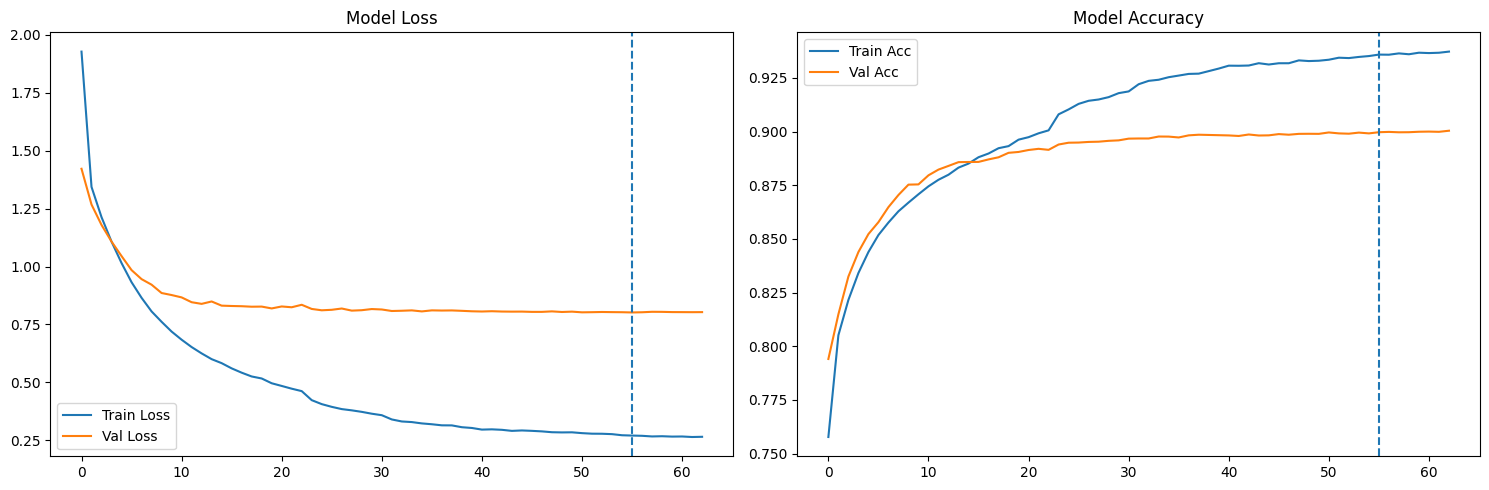


RINGKASAN TRAINING
Best Epoch              : 56
Train Loss              : 0.2704
Train Accuracy          : 0.9358
Validation Loss         : 0.8017
Validation Accuracy     : 0.8997
Training Time (minutes) : 193.55


In [ ]:
# =====================================================================
# 6. KOMPILASI DAN PELATIHAN MODEL
# =====================================================================
print("=" * 80)
print("6. KOMPILASI DAN PELATIHAN MODEL")
print("=" * 80)

# =====================================================================
# KOMPILASI MODEL
# =====================================================================
print("\n🔧 Mengkompilasi Model...")

optimizer = Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)

training_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"   ✅ Optimizer: Adam (lr={LEARNING_RATE}, clipnorm=1.0)")
print(f"   ✅ Loss: Sparse Categorical Crossentropy")
print(f"   ✅ Metrics: Accuracy")

# =====================================================================
# CALLBACKS
# =====================================================================
print("\n🔧 Menyiapkan Callbacks...")

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=EARLY_STOPPING_PATIENCE,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    filepath=f'{MODEL_SAVE_PATH}best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

csv_logger = CSVLogger(
    f'{MODEL_SAVE_PATH}training_log.csv',
    append=False
)

callbacks_list = [
    early_stopping,
    model_checkpoint,
    reduce_lr,
    csv_logger
]

# =====================================================================
# TRAINING
# =====================================================================
print("\n" + "=" * 80)
print("MEMULAI PELATIHAN MODEL")
print("=" * 80)

start_time = time.time()

history = training_model.fit(
    x=[X_train, y_train_in],
    y=y_train_out,
    validation_data=([X_val, y_val_in], y_val_out),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    shuffle=True,
    verbose=1
)

training_time = time.time() - start_time

# =====================================================================
# BEST EPOCH (KONSISTEN — BERDASARKAN VAL_LOSS)
# =====================================================================
best_epoch = np.argmin(history.history['val_loss'])

best_train_loss = history.history['loss'][best_epoch]
best_train_acc = history.history['accuracy'][best_epoch]
best_val_loss = history.history['val_loss'][best_epoch]
best_val_acc = history.history['val_accuracy'][best_epoch]

print("\n⭐ BEST MODEL PERFORMANCE (CONSISTENT)")
print(f"   • Epoch                : {best_epoch + 1}")
print(f"   • Train Loss           : {best_train_loss:.4f}")
print(f"   • Train Accuracy       : {best_train_acc:.4f}")
print(f"   • Validation Loss      : {best_val_loss:.4f}")
print(f"   • Validation Accuracy  : {best_val_acc:.4f}")

# =====================================================================
# MENYIMPAN MODEL FINAL (TIDAK DIUBAH)
# =====================================================================
print("\n🔧 Menyimpan model dan artifacts...")

training_model.save(f'{MODEL_SAVE_PATH}final_model.keras')
print(f"   ✅ Model final: {MODEL_SAVE_PATH}final_model.keras")

with open(f'{MODEL_SAVE_PATH}eng_tokenizer.pkl', 'wb') as f:
    pickle.dump(eng_tokenizer, f)

with open(f'{MODEL_SAVE_PATH}jv_tokenizer.pkl', 'wb') as f:
    pickle.dump(jv_tokenizer, f)

metadata = {
    'eng_vocab_size': eng_vocab_size,
    'jv_vocab_size': jv_vocab_size,
    'max_len_eng': max_len_eng,
    'max_len_jv': max_len_jv,
    'embedding_dim': EMBEDDING_DIM,
    'jv_embedding_dim': JV_EMBEDDING_DIM,
    'lstm_units': LSTM_UNITS,
    'dropout_rate': DROPOUT_RATE,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'total_params': total_params,
    'training_samples': len(X_train),
    'validation_samples': len(X_val),
    'best_epoch': int(best_epoch + 1),
    'best_val_loss': float(best_val_loss),
    'best_val_accuracy': float(best_val_acc),
    'epochs_trained': len(history.history['loss']),
    'training_time_minutes': training_time / 60
}

with open(f'{MODEL_SAVE_PATH}model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

print("\n✅ Semua artifacts berhasil disimpan!")

# =====================================================================
# VISUALISASI TRAINING HISTORY (KONSISTEN)
# =====================================================================
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].axvline(best_epoch, linestyle='--')
axes[0].set_title('Model Loss')
axes[0].legend()

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Acc')
axes[1].plot(history.history['val_accuracy'], label='Val Acc')
axes[1].axvline(best_epoch, linestyle='--')
axes[1].set_title('Model Accuracy')
axes[1].legend()

plt.tight_layout()
plt.savefig(f'{MODEL_SAVE_PATH}training_history.png', dpi=150)
plt.show()

# =====================================================================
# TRAINING SUMMARY (BENAR SECARA ILMIAH)
# =====================================================================
print("\n" + "=" * 80)
print("RINGKASAN TRAINING")
print("=" * 80)
print(f"Best Epoch              : {best_epoch + 1}")
print(f"Train Loss              : {best_train_loss:.4f}")
print(f"Train Accuracy          : {best_train_acc:.4f}")
print(f"Validation Loss         : {best_val_loss:.4f}")
print(f"Validation Accuracy     : {best_val_acc:.4f}")
print(f"Training Time (minutes) : {training_time / 60:.2f}")
print("=" * 80)


In [ ]:
# 7. PENYIMPANAN MODEL
print("=" * 80)
print("7. MENYIMPAN MODEL DAN ARTIFACTS")
print("=" * 80)

# Simpan model training lengkap
model_path = os.path.join(MODEL_SAVE_PATH, 'nmt_en_jv_attention_model.keras')
training_model.save(model_path)
print(f"✅ Model lengkap disimpan: {model_path}")

# Simpan weights saja (lebih kecil)
weights_path = os.path.join(MODEL_SAVE_PATH, 'model.weights.h5')
training_model.save_weights(weights_path)
print(f"✅ Model weights disimpan: {weights_path}")

tokenizer_path_en = os.path.join(MODEL_SAVE_PATH, 'eng_tokenizer.json')
with open(tokenizer_path_en, 'w', encoding='utf-8') as f:
    f.write(eng_tokenizer.to_json())
print(f"✅ English tokenizer disimpan (JSON): {tokenizer_path_en}")

tokenizer_path_jv = os.path.join(MODEL_SAVE_PATH, 'jv_tokenizer.json')
with open(tokenizer_path_jv, 'w', encoding='utf-8') as f:
    f.write(jv_tokenizer.to_json())
print(f"✅ Javanese tokenizer disimpan (JSON): {tokenizer_path_jv}")

# Simpan configuration
config = {
    'eng_vocab_size': eng_vocab_size,
    'jv_vocab_size': jv_vocab_size,
    'max_len_eng': max_len_eng,
    'max_len_jv': max_len_jv,
    'embedding_dim': EMBEDDING_DIM,
    'jv_embedding_dim': JV_EMBEDDING_DIM,
    'lstm_units': LSTM_UNITS,
    'dropout_rate': DROPOUT_RATE
}

config_path = os.path.join(MODEL_SAVE_PATH, 'model_config.json')
with open(config_path, 'w') as f:
    json.dump(config, f, indent=4)
print(f"✅ Model config disimpan: {config_path}")

print("\n" + "=" * 80)
print("SEMUA ARTIFACTS BERHASIL DISIMPAN")
print("=" * 80 + "\n")

# ============================================================================
# 8. PERANCANGAN MODEL INFERENSI DENGAN ATTENTION
# ============================================================================
print("=" * 80)
print("8. MEMBANGUN MODEL INFERENSI (UNTUK TRANSLASI)")
print("=" * 80)

# ============================================================================
# ENCODER INFERENCE MODEL
# ============================================================================
print("\n🔧 Membangun Encoder Inference Model...")

# ✅ Encoder inference: Return encoder_outputs dan states
# Input: kalimat English
# Output: [encoder_outputs, state_h, state_c]
inference_encoder_model = Model(
    inputs=encoder_inputs,
    outputs=[encoder_outputs, state_h, state_c],
    name='encoder_inference'
)

print(f"   ✅ Input: {inference_encoder_model.input.shape}")
print(f"   ✅ Outputs:")
print(f"       - encoder_outputs: {inference_encoder_model.output[0].shape}")
print(f"       - state_h: {inference_encoder_model.output[1].shape}")
print(f"       - state_c: {inference_encoder_model.output[2].shape}")

# ============================================================================
# DECODER INFERENCE MODEL
# ============================================================================
print("\n🔧 Membangun Decoder Inference Model...")

# ✅ Input 1: Single token dari decoder (kata saat ini)
decoder_input_single = Input(shape=(1,), name='decoder_input_single')

# ✅ Input 2: Hidden states dari step sebelumnya
decoder_state_h_input = Input(shape=(LSTM_UNITS,), name='decoder_state_h_input')
decoder_state_c_input = Input(shape=(LSTM_UNITS,), name='decoder_state_c_input')
decoder_states_input = [decoder_state_h_input, decoder_state_c_input]

# ✅ Input 3: Encoder outputs untuk attention (dari encoder inference)
encoder_outputs_input = Input(shape=(max_len_eng, LSTM_UNITS), name='encoder_outputs_input')

# ✅ Embedding untuk single token
# PENTING: Gunakan kembali layer embedding dari Bagian 5
dec_emb_single = decoder_embedding_layer(decoder_input_single)

# ✅ LSTM untuk single step dengan states dari step sebelumnya
# PENTING: Gunakan kembali layer LSTM dari Bagian 5
decoder_outputs_single, state_h_output, state_c_output = decoder_lstm(
    dec_emb_single,
    initial_state=decoder_states_input
)
decoder_states_output = [state_h_output, state_c_output]

# ✅ Attention mechanism untuk single step
# PENTING: Gunakan kembali layer Attention dari Bagian 5
context_vector_single, attention_weights_single = attention_layer(
    [encoder_outputs_input, decoder_outputs_single]
)

# ✅ Concatenate decoder output dengan context vector
decoder_concat_single = Concatenate(axis=-1, name='concat_single')(
    [decoder_outputs_single, context_vector_single]
)

# ⭐️ PERBAIKAN KUNCI 1:
# Gunakan kembali layer 'dense_transform_layer' yang sama dari Bagian 5.
# JANGAN buat layer Dense baru di sini.
decoder_concat_single = dense_transform_layer(decoder_concat_single)

# ⭐️ PERBAIKAN KUNCI 2:
# Gunakan kembali layer 'decoder_dense' (softmax) yang sama dari Bagian 5.
decoder_output_single = decoder_dense(decoder_concat_single)

# ✅ Model inference decoder
inference_decoder_model = Model(
    inputs=[decoder_input_single, decoder_states_input, encoder_outputs_input],
    outputs=[decoder_output_single, decoder_states_output, attention_weights_single],
    name='decoder_inference'
)

print(f"   ✅ Inputs:")
print(f"       - decoder_input: {inference_decoder_model.input[0].shape}")
print(f"       - state_h_input: {inference_decoder_model.input[1][0].shape}")
print(f"       - state_c_input: {inference_decoder_model.input[1][1].shape}")
print(f"       - encoder_outputs: {inference_decoder_model.input[2].shape}")

print(f"   ✅ Outputs:")
print(f"       - predictions: {inference_decoder_model.output[0].shape}")
print(f"       - state_h_output: {inference_decoder_model.output[1][0].shape}")
print(f"       - state_c_output: {inference_decoder_model.output[1][1].shape}")
print(f"       - attention_weights: {inference_decoder_model.output[2].shape}")


print("\n" + "=" * 80)
print("✅ MODEL INFERENSI BERHASIL DIBANGUN")
print("=" * 80 + "\n")

# ============================================================================
# SIMPAN MODEL INFERENSI
# ============================================================================
print("🔧 Menyimpan model inferensi...")

encoder_inf_path = os.path.join(MODEL_SAVE_PATH, 'encoder_inference_model.keras')
decoder_inf_path = os.path.join(MODEL_SAVE_PATH, 'decoder_inference_model.keras')

inference_encoder_model.save(encoder_inf_path)
inference_decoder_model.save(decoder_inf_path)

print(f"✅ Encoder inference disimpan: {encoder_inf_path}")
print(f"✅ Decoder inference disimpan: {decoder_inf_path}")
print()

# ============================================================================
# VERIFIKASI MODEL INFERENSI
# ============================================================================
print("🧪 Verifikasi Model Inferensi...")

try:
    # Test dengan dummy input
    test_input = np.random.randint(1, eng_vocab_size, size=(1, max_len_eng))

    # Encoder inference
    test_enc_outputs, test_state_h, test_state_c = inference_encoder_model.predict(
        test_input, verbose=0
    )
    print(f"   ✅ Encoder test passed!")
    print(f"       - encoder_outputs shape: {test_enc_outputs.shape}")

    # Decoder inference
    test_dec_input = np.array([[jv_tokenizer.word_index.get('<start>', 1)]])

    test_pred, test_states, test_attn = inference_decoder_model.predict(
    [
        test_dec_input,              # Input token
        [test_state_h, test_state_c],# States (HARUS berupa list)
        test_enc_outputs             # Encoder outputs
    ],
    verbose=0
    )
    print(f"   ✅ Decoder test passed!")
    print(f"       - predictions shape: {test_pred.shape}")
    print(f"       - attention shape: {test_attn.shape}")

    print("\n✅ Model inferensi siap digunakan untuk translasi!")

except Exception as e:
    print(f"   ⚠️ Verification warning: {e}")
    print("   💡 Model inferensi mungkin perlu adjustment")

print("\n" + "=" * 80 + "\n")

7. MENYIMPAN MODEL DAN ARTIFACTS
✅ Model lengkap disimpan: /content/drive/MyDrive/Colab Notebooks/model_skripsi_glove_fasttext_attention_LSTM_4/nmt_en_jv_attention_model.keras
✅ Model weights disimpan: /content/drive/MyDrive/Colab Notebooks/model_skripsi_glove_fasttext_attention_LSTM_4/model.weights.h5
✅ English tokenizer disimpan (JSON): /content/drive/MyDrive/Colab Notebooks/model_skripsi_glove_fasttext_attention_LSTM_4/eng_tokenizer.json
✅ Javanese tokenizer disimpan (JSON): /content/drive/MyDrive/Colab Notebooks/model_skripsi_glove_fasttext_attention_LSTM_4/jv_tokenizer.json
✅ Model config disimpan: /content/drive/MyDrive/Colab Notebooks/model_skripsi_glove_fasttext_attention_LSTM_4/model_config.json

SEMUA ARTIFACTS BERHASIL DISIMPAN

8. MEMBANGUN MODEL INFERENSI (UNTUK TRANSLASI)

🔧 Membangun Encoder Inference Model...
   ✅ Input: (None, 34)
   ✅ Outputs:
       - encoder_outputs: (None, 34, 128)
       - state_h: (None, 128)
       - state_c: (None, 128)

🔧 Membangun Decoder Inf

9. MEMBUAT FUNGSI PENERJEMAHAN (INFERENCE)
✅ Fungsi 'translate_sentence' berhasil dibuat!

🧪 Testing fungsi translate...

Contoh Terjemahan:
------------------------------------------------------------
1. EN: Hello!
   JV: !

2. EN: How are you?
   JV: apa ?

3. EN: Welcome!
   JV: ! !

4. EN: Good morning.
   JV: esuk .

5. EN: Thank you very much.
   JV: matur nuwun sanget banget .


10. EVALUASI MODEL DENGAN BLEU SCORE

EVALUASI PADA VALIDATION SET

🔍 Mengevaluasi 100 sampel...


Translating: 100%|██████████| 100/100 [01:41<00:00,  1.02s/it]



📊 Menghitung BLEU scores...

HASIL EVALUASI BLEU

📊 BLEU Scores (100 samples):
----------------------------------------
   BLEU-1      : 0.7263 (72.63%)
   BLEU-2      : 0.5367 (53.67%)
   BLEU-3      : 0.4105 (41.05%)
   BLEU-4      : 0.3079 (30.79%)

📈 Membuat visualisasi BLEU scores...


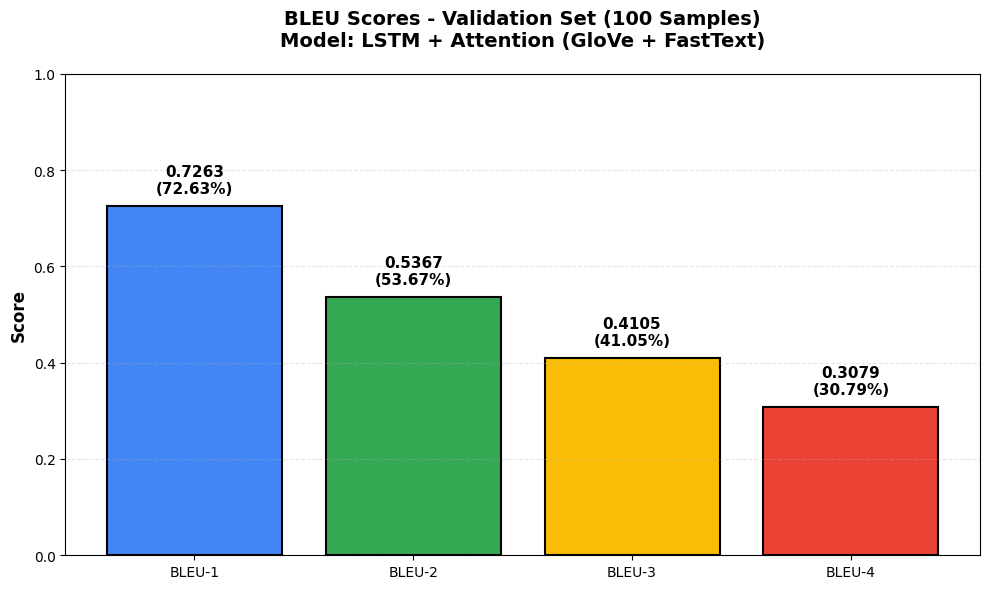

✅ Grafik disimpan: /content/drive/MyDrive/Colab Notebooks/model_skripsi_glove_fasttext_attention_LSTM_4/bleu_scores_validation.png

CONTOH TERJEMAHAN (10 Sampel)

Contoh 1:
Input (EN)    : If Tom wants me to do that, I will.
Reference (JV): Yen Tom pengin aku nglakoni, aku bakal.
Prediction    : yen tom pengin aku nglakoni .
BLEU Score    : 0.4720

Contoh 2:
Input (EN)    : Sami took Layla to the doctor's.
Reference (JV): Sami nggawa Layla menyang dokter.
Prediction    : sami njupuk layla kanggo fbi .
BLEU Score    : 0.1331

Contoh 3:
Input (EN)    : The weather changes very often in England.
Reference (JV): Cuaca asring ganti ing Inggris.
Prediction    : cuaca luwih unggul banget ing inggris .
BLEU Score    : 0.1234

Contoh 4:
Input (EN)    : Sitting under a shady tree.
Reference (JV): Lungguh ing ngisor wit sing rindang.
Prediction    : lungguh ing ndhuwur wit .
BLEU Score    : 0.1933

Contoh 5:
Input (EN)    : A Mr Jones has come to see you.
Reference (JV): A Pak Jones wis teka kang

In [ ]:
# ============================================================================
# 9. FUNGSI PENERJEMAHAN DENGAN ATTENTION
# ============================================================================
print("=" * 80)
print("9. MEMBUAT FUNGSI PENERJEMAHAN (INFERENCE)")
print("=" * 80)

def translate_sentence(input_sentence, max_output_length=None, return_attention=False, debug=False):
    """
    Fungsi gabungan: Inference + Debugging
    """
    if max_output_length is None:
        max_output_length = max_len_jv

    # 1. Preprocess
    processed_input = preprocess_english(input_sentence)

    # 2. Tokenizing
    input_seq = eng_tokenizer.texts_to_sequences([processed_input])

    # --- DEBUG SECTION (Untuk cek OOV / Kata tidak dikenali) ---
    if debug:
        print(f"\n[DEBUG] Input Asli: '{input_sentence}'")
        print(f"[DEBUG] Preprocessed: '{processed_input}'")
        tokens_in_text = processed_input.split()
        recognized_tokens = []
        for word in tokens_in_text:
            if word in eng_tokenizer.word_index:
                recognized_tokens.append(word)
            else:
                recognized_tokens.append(f"[{word}???]") # Tandai OOV
        print(f"[DEBUG] Yang dilihat model: {' '.join(recognized_tokens)}")
        print(f"[DEBUG] Sequence Indices: {input_seq}")
    # -----------------------------------------------------------

    # 3. Padding
    input_seq = pad_sequences(input_seq, maxlen=max_len_eng, padding='post')

    # ========================================================================
    # LOGIKA INFERENCE (DARI SECTION 9) - DIMASUKKAN KEMBALI
    # ========================================================================

    # 4. Encoder Inference
    encoder_outputs_val, state_h, state_c = inference_encoder_model.predict(
        input_seq, verbose=0
    )
    states_value = [state_h, state_c]

    # 5. Siapkan Decoder Input (<start>)
    target_seq = np.zeros((1, 1))
    start_token = jv_tokenizer.word_index.get('<start>', 1)
    target_seq[0, 0] = start_token

    # Variables output
    stop_condition = False
    decoded_sentence = ''
    decoded_tokens = []
    attention_weights_list = [] if return_attention else None

    # 6. Decoding Loop
    step = 0
    while not stop_condition:
        output_tokens, new_states, attention_weights = inference_decoder_model.predict(
            [target_seq, states_value, encoder_outputs_val],
            verbose=0
        )

        if return_attention:
            attention_weights_list.append(attention_weights[0, 0, :])

        # Ambil token dengan probabilitas tertinggi
        sampled_token_index = np.argmax(output_tokens[0, 0, :])
        sampled_word = jv_tokenizer.index_word.get(sampled_token_index, '')

        # Cek kondisi berhenti
        if sampled_word == '<end>' or sampled_word == '':
            stop_condition = True
        elif step >= max_output_length:
            stop_condition = True
        else:
            decoded_tokens.append(sampled_word)
            decoded_sentence += sampled_word + ' '

        # Update state untuk iterasi selanjutnya
        target_seq[0, 0] = sampled_token_index
        states_value = new_states
        step += 1

    decoded_sentence = decoded_sentence.strip()

    if return_attention:
        return decoded_sentence, np.array(attention_weights_list)
    else:
        return decoded_sentence

print("✅ Fungsi 'translate_sentence' berhasil dibuat!\n")

# ============================================================================
# Test fungsi translate
# ============================================================================
print("🧪 Testing fungsi translate...\n")

test_sentences = [
    "Hello!",
    "How are you?",
    "Welcome!",
    "Good morning.",
    "Thank you very much."
]

print("Contoh Terjemahan:")
print("-" * 60)
for idx, test_sent in enumerate(test_sentences, 1):
    translation = translate_sentence(test_sent)
    print(f"{idx}. EN: {test_sent}")
    print(f"   JV: {translation}\n")

print("=" * 80 + "\n")

# ============================================================================
# 10. EVALUASI BLEU SCORE
# ============================================================================
print("=" * 80)
print("10. EVALUASI MODEL DENGAN BLEU SCORE")
print("=" * 80)

def calculate_bleu_scores(encoded_sources, raw_dataframe, num_samples=None, verbose=True):
    """
    Menghitung BLEU scores untuk evaluasi model

    Args:
        encoded_sources: Encoded input sequences
        raw_dataframe: DataFrame dengan kolom 'english' dan 'javanese'
        num_samples: Jumlah sampel yang dievaluasi (None = semua)
        verbose: Print progress

    Returns:
        dict: BLEU scores dan detail evaluasi
    """
    if num_samples is None or num_samples > len(raw_dataframe):
        num_samples = len(raw_dataframe)

    actual = []       # Reference translations
    predicted = []    # Model predictions
    examples = []     # Contoh untuk analisis

    if verbose:
        print(f"\n🔍 Mengevaluasi {num_samples} sampel...")
        iterator = tqdm(range(num_samples), desc="Translating")
    else:
        iterator = range(num_samples)

    for i in iterator:
        # ✅ Ambil input English dari dataframe (bukan dari encoded)
        input_text = raw_dataframe.iloc[i]['english']

        # Terjemahkan
        try:
            translation = translate_sentence(input_text)
        except Exception as e:
            if verbose:
                print(f"\n⚠️ Error translating sample {i}: {e}")
            translation = ""

        # ✅ Ambil target asli (reference)
        raw_target = raw_dataframe.iloc[i]['javanese']

        # ✅ Tokenize untuk BLEU calculation
        # Reference harus dalam list of lists (bisa ada multiple references)
        reference_tokens = raw_target.lower().split()
        predicted_tokens = translation.lower().split()

        actual.append([reference_tokens])  # List of list untuk multiple references
        predicted.append(predicted_tokens)

        # Simpan beberapa contoh untuk analisis
        if len(examples) < 10:
            examples.append({
                'input': input_text,
                'reference': raw_target,
                'prediction': translation
            })

    # ✅ Hitung BLEU scores dengan smoothing
    smooth = SmoothingFunction()

    print("\n📊 Menghitung BLEU scores...")
    bleu_scores = {}

    # BLEU-1 (unigram precision)
    bleu_scores['BLEU-1'] = corpus_bleu(
        actual, predicted,
        weights=(1.0, 0, 0, 0),
        smoothing_function=smooth.method7
    )

    # BLEU-2 (unigram + bigram)
    bleu_scores['BLEU-2'] = corpus_bleu(
        actual, predicted,
        weights=(0.5, 0.5, 0, 0),
        smoothing_function=smooth.method7
    )

    # BLEU-3 (unigram + bigram + trigram)
    bleu_scores['BLEU-3'] = corpus_bleu(
        actual, predicted,
        weights=(0.33, 0.33, 0.34, 0),
        smoothing_function=smooth.method7
    )

    # BLEU-4 (standard BLEU)
    bleu_scores['BLEU-4'] = corpus_bleu(
        actual, predicted,
        weights=(0.25, 0.25, 0.25, 0.25),
        smoothing_function=smooth.method7
    )

    return {
        'scores': bleu_scores,
        'examples': examples,
        'num_samples': num_samples,
        'actual': actual,
        'predicted': predicted
    }

# ============================================================================
# Evaluasi pada Dataset Validasi
# ============================================================================
print("\n" + "=" * 80)
print("EVALUASI PADA VALIDATION SET")
print("=" * 80)

# ✅ Evaluasi dengan 100 sampel (atau sesuaikan)
NUM_EVAL_SAMPLES = min(100, len(X_val))

results_val = calculate_bleu_scores(
    X_val,
    val_df,
    num_samples=NUM_EVAL_SAMPLES,
    verbose=True
)

bleu_val = results_val['scores']

# ============================================================================
# Tampilkan Hasil BLEU
# ============================================================================
print("\n" + "=" * 80)
print("HASIL EVALUASI BLEU")
print("=" * 80)
print(f"\n📊 BLEU Scores ({NUM_EVAL_SAMPLES} samples):")
print("-" * 40)
for metric, score in bleu_val.items():
    print(f"   {metric:12s}: {score:.4f} ({score*100:.2f}%)")

# ============================================================================
# Visualisasi BLEU Scores
# ============================================================================
print("\n📈 Membuat visualisasi BLEU scores...")

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#4285F4', '#34A853', '#FBBC05', '#EA4335']
bars = ax.bar(
    x=bleu_val.keys(),
    height=bleu_val.values(),
    color=colors,
    edgecolor='black',
    linewidth=1.5
)

ax.set_title(
    f"BLEU Scores - Validation Set ({NUM_EVAL_SAMPLES} Samples)\n" +
    "Model: LSTM + Attention (GloVe + FastText)",
    fontsize=14,
    fontweight='bold',
    pad=20
)
ax.set_ylabel("Score", fontsize=12, fontweight='bold')
ax.set_ylim((0, 1))
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Tambahkan nilai di atas bar
for i, (bar, v) in enumerate(zip(bars, bleu_val.values())):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2., height + 0.02,
        f'{v:.4f}\n({v*100:.2f}%)',
        ha='center', va='bottom',
        fontweight='bold',
        fontsize=11
    )

plt.tight_layout()
plt.savefig(f'{MODEL_SAVE_PATH}bleu_scores_validation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Grafik disimpan: {MODEL_SAVE_PATH}bleu_scores_validation.png")

# ============================================================================
# Tampilkan Contoh Terjemahan
# ============================================================================
print("\n" + "=" * 80)
print("CONTOH TERJEMAHAN (10 Sampel)")
print("=" * 80 + "\n")

for idx, example in enumerate(results_val['examples'], 1):
    print(f"{'='*60}")
    print(f"Contoh {idx}:")
    print(f"{'='*60}")
    print(f"Input (EN)    : {example['input']}")
    print(f"Reference (JV): {example['reference']}")
    print(f"Prediction    : {example['prediction']}")

    # Hitung BLEU untuk kalimat individual
    ref_tokens = [example['reference'].lower().split()]
    pred_tokens = example['prediction'].lower().split()

    try:
        sent_bleu = sentence_bleu(
            ref_tokens, pred_tokens,
            smoothing_function=SmoothingFunction().method7
        )
        print(f"BLEU Score    : {sent_bleu:.4f}")
    except:
        print(f"BLEU Score    : N/A")
    print()

print("\n" + "=" * 80)
print("✅ EVALUASI SELESAI!")
print("=" * 80 + "\n")

In [ ]:
# ============================================================================
# Evaluasi pada Dataset Test
# ============================================================================
print("\n" + "=" * 80)
print("EVALUASI PADA TEST SET")
print("=" * 80)

NUM_TEST_SAMPLES = min(100, len(X_test))

results_test = calculate_bleu_scores(
    X_test,
    test_df,
    num_samples=NUM_TEST_SAMPLES,
    verbose=True
)

bleu_test = results_test['scores']

print("\n📊 BLEU Scores (TEST SET):")
print("-" * 40)
for metric, score in bleu_test.items():
    print(f"   {metric:12s}: {score:.4f} ({score*100:.2f}%)")



EVALUASI PADA TEST SET

🔍 Mengevaluasi 100 sampel...


Translating: 100%|██████████| 100/100 [01:36<00:00,  1.03it/s]


📊 Menghitung BLEU scores...

📊 BLEU Scores (TEST SET):
----------------------------------------
   BLEU-1      : 0.6937 (69.37%)
   BLEU-2      : 0.5018 (50.18%)
   BLEU-3      : 0.3691 (36.91%)
   BLEU-4      : 0.3421 (34.21%)


In [ ]:
# ============================================================================
# 11. DEMO PENERJEMAHAN INTERAKTIF (USER TESTING) - FIXED VERSION
# ============================================================================

# Kita definisikan ulang fungsi translate agar mensupport debug print
def translate_sentence(input_sentence, max_output_length=None, return_attention=False, debug=False):
    if max_output_length is None:
        max_output_length = max_len_jv

    # 1. Preprocess
    processed_input = preprocess_english(input_sentence)

    # 2. Tokenizing
    input_seq = eng_tokenizer.texts_to_sequences([processed_input])

    # --- DEBUG SECTION (Untuk melihat apa yang dilihat model) ---
    if debug:
        print(f"\n[DEBUG] Input Asli: '{input_sentence}'")
        print(f"[DEBUG] Preprocessed: '{processed_input}'")
        tokens_in_text = processed_input.split()
        recognized_tokens = []
        for word in tokens_in_text:
            if word in eng_tokenizer.word_index:
                recognized_tokens.append(word)
            else:
                recognized_tokens.append(f"[{word}???]") # Tandai kata yang tidak dikenali
        print(f"[DEBUG] Yang dilihat model: {' '.join(recognized_tokens)}")
        print(f"[DEBUG] Sequence Indices: {input_seq}")
    # -----------------------------------------------------------

    # 3. Padding
    input_seq = pad_sequences(input_seq, maxlen=max_len_eng, padding='post')

    # ========================================================================
    # LOGIKA INFERENCE (DARI SECTION 9) - WAJIB ADA DI SINI
    # ========================================================================

    # 4. Encoder Inference
    encoder_outputs_val, state_h, state_c = inference_encoder_model.predict(
        input_seq, verbose=0
    )
    states_value = [state_h, state_c]

    # 5. Siapkan Decoder Input (<start>)
    target_seq = np.zeros((1, 1))
    start_token = jv_tokenizer.word_index.get('<start>', 1)
    target_seq[0, 0] = start_token

    # Variables output
    stop_condition = False
    decoded_sentence = ''
    decoded_tokens = []
    attention_weights_list = [] if return_attention else None

    # 6. Decoding Loop
    step = 0
    while not stop_condition:
        output_tokens, new_states, attention_weights = inference_decoder_model.predict(
            [target_seq, states_value[0], states_value[1], encoder_outputs_val],
            verbose=0
        )

        if return_attention:
            attention_weights_list.append(attention_weights[0, 0, :])

        # Ambil token dengan probabilitas tertinggi
        sampled_token_index = np.argmax(output_tokens[0, 0, :])
        sampled_word = jv_tokenizer.index_word.get(sampled_token_index, '')

        # Cek kondisi berhenti
        if sampled_word == '<end>' or sampled_word == '':
            stop_condition = True
        elif step >= max_output_length:
            stop_condition = True
        else:
            decoded_tokens.append(sampled_word)
            decoded_sentence += sampled_word + ' '

        # Update state untuk iterasi selanjutnya
        target_seq[0, 0] = sampled_token_index
        states_value = new_states
        step += 1

    decoded_sentence = decoded_sentence.strip()

    if return_attention:
        return decoded_sentence, np.array(attention_weights_list)
    else:
        return decoded_sentence

def interactive_translation_session():
    print("=" * 60)
    print("🤖 PROGRAM PENERJEMAH INGGRIS -> JAWA (NMT LSTM + ATTENTION)")
    print("=" * 60)
    print("Instruksi:")
    print("1. Ketik kalimat bahasa Inggris yang ingin diterjemahkan.")
    print("2. Ketik 'debug' di awal kalimat untuk melihat proses (contoh: debug hello).")
    print("3. Ketik 'q', 'quit', atau 'keluar' untuk menghentikan program.")
    print("-" * 60)

    while True:
        try:
            # 1. Input User
            input_text = input("\n🇬🇧 Masukkan kalimat (English): ")

            # 2. Cek kondisi berhenti
            if input_text.lower() in ['q', 'quit', 'keluar', 'exit']:
                print("\n👋 Terima kasih! Program dihentikan.")
                print("=" * 60)
                break

            # 3. Validasi input kosong
            if not input_text.strip():
                print("⚠️  Input tidak boleh kosong.")
                continue

            # 4. Cek mode debug
            debug_mode = False
            if input_text.lower().startswith("debug "):
                debug_mode = True
                input_text = input_text[6:] # Hapus kata 'debug '

            # 5. Proses Penerjemahan
            translation = translate_sentence(input_text, debug=debug_mode)

            # 6. Tampilkan Hasil
            print(f"🇮🇩 Terjemahan (Jawa)   : {translation}")

        except KeyboardInterrupt:
            print("\n\n👋 Program dihentikan paksa oleh pengguna.")
            break
        except Exception as e:
            print(f"❌ Terjadi kesalahan: {e}")
            # print("Detail:", sys.exc_info()) # Uncomment jika ingin melihat detail error

# Jalankan fungsi
interactive_translation_session()

🤖 PROGRAM PENERJEMAH INGGRIS -> JAWA (NMT LSTM + ATTENTION)
Instruksi:
1. Ketik kalimat bahasa Inggris yang ingin diterjemahkan.
2. Ketik 'debug' di awal kalimat untuk melihat proses (contoh: debug hello).
3. Ketik 'q', 'quit', atau 'keluar' untuk menghentikan program.
------------------------------------------------------------

🇬🇧 Masukkan kalimat (English): On the lamp


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['decoder_input_single', ['decoder_state_h_input', 'decoder_state_c_input'], 'encoder_outputs_input']
Received: inputs=('Tensor(shape=(1, 1))', 'Tensor(shape=(1, 128))', 'Tensor(shape=(1, 128))', 'Tensor(shape=(1, 34, 128))')
  warnings.warn(msg)


🇮🇩 Terjemahan (Jawa)   : lampu mudhun

🇬🇧 Masukkan kalimat (English): one
🇮🇩 Terjemahan (Jawa)   : siji .

🇬🇧 Masukkan kalimat (English): two
🇮🇩 Terjemahan (Jawa)   : .

🇬🇧 Masukkan kalimat (English): three
🇮🇩 Terjemahan (Jawa)   : telu .

🇬🇧 Masukkan kalimat (English): four
🇮🇩 Terjemahan (Jawa)   : .

🇬🇧 Masukkan kalimat (English): five
🇮🇩 Terjemahan (Jawa)   : 1994 .

🇬🇧 Masukkan kalimat (English): six
🇮🇩 Terjemahan (Jawa)   : 2013 .

🇬🇧 Masukkan kalimat (English): seven
🇮🇩 Terjemahan (Jawa)   : telu .

🇬🇧 Masukkan kalimat (English): eight
🇮🇩 Terjemahan (Jawa)   : wolung depan .

🇬🇧 Masukkan kalimat (English): nine
🇮🇩 Terjemahan (Jawa)   : telu .

🇬🇧 Masukkan kalimat (English): ten
🇮🇩 Terjemahan (Jawa)   : biasane .

🇬🇧 Masukkan kalimat (English): hello
🇮🇩 Terjemahan (Jawa)   : halo !

🇬🇧 Masukkan kalimat (English): what are you doing
🇮🇩 Terjemahan (Jawa)   : nindakake iku nglakoni .

🇬🇧 Masukkan kalimat (English): left
🇮🇩 Terjemahan (Jawa)   : .

🇬🇧 Masukkan kalimat (English): live


## Evaluasi

In [ ]:
# 10. PENERJEMAHAN INTERAKTIF
print("\n--- Memulai Mode Penerjemahan Interaktif ---")
while True:
    input_text = input("\nMasukkan kalimat Bahasa Inggris (ketik 'keluar' untuk berhenti): ")
    if input_text.lower() == 'keluar':
        print("Terima kasih!")
        break
    translated_text = translate_sentence(input_text)
    print(f"Hasil Terjemahan (JV): {translated_text}")


--- Memulai Mode Penerjemahan Interaktif ---

Masukkan kalimat Bahasa Inggris (ketik 'keluar' untuk berhenti): Angga isn't actually going to do that today, is he?
Hasil Terjemahan (JV): apa sing bakal angel , ta ?

Masukkan kalimat Bahasa Inggris (ketik 'keluar' untuk berhenti): Tom isn't actually going to do that today, is he?
Hasil Terjemahan (JV): tom ora bakal nindakake dina iki ?

Masukkan kalimat Bahasa Inggris (ketik 'keluar' untuk berhenti): Say goodbye to your friends.
Hasil Terjemahan (JV): pamita marang kanca-kancamu .

Masukkan kalimat Bahasa Inggris (ketik 'keluar' untuk berhenti): What do you think?
Hasil Terjemahan (JV): apa sing kok lakoni ?

Masukkan kalimat Bahasa Inggris (ketik 'keluar' untuk berhenti): You'll be safe here.
Hasil Terjemahan (JV): sampeyan bakal aman .

Masukkan kalimat Bahasa Inggris (ketik 'keluar' untuk berhenti): keluar
Terima kasih!


In [ ]:
def cek_kata_di_kamus(kalimat):
    # 1. Preprocess dulu (supaya adil, sama seperti saat training)
    kalimat_clean = preprocess_english(kalimat)
    words = kalimat_clean.split()

    print(f"Kalimat asli: '{kalimat}'")
    print(f"Setelah clean : '{kalimat_clean}'")
    print("-" * 40)
    print(f"{'KATA':<15} | {'STATUS':<15} | {'ID TOKEN'}")
    print("-" * 40)

    ada_oov = False
    for word in words:
        # Cek di word_index milik eng_tokenizer
        if word in eng_tokenizer.word_index:
            token_id = eng_tokenizer.word_index[word]
            print(f"{word:<15} | ✅ ADA            | {token_id}")
        else:
            print(f"{word:<15} | ❌ TIDAK ADA      | <unk>")
            ada_oov = True

    if ada_oov:
        print("-" * 40)
        print("💡 KESIMPULAN: Ada kata yang TIDAK DIKENALI (OOV).")
        print("   Model akan melihatnya sebagai token <unk> dan menebak-nebak artinya.")
    else:
        print("-" * 40)
        print("✅ Semua kata dikenali.")
    print("=" * 60 + "\n")

# ==========================================
# Cek Kalimat dari Log Anda Tadi
# ==========================================

# Kasus 1: China jadi minggu
cek_kata_di_kamus("I wrote a book about China.")

# Kasus 2: Deprived jadi lara
cek_kata_di_kamus("The whole city was deprived of water.")

# Kasus 3: Eight o'clock jadi kacau
cek_kata_di_kamus("It's eight o'clock.")

# Kasus 4: Typo
cek_kata_di_kamus("nearby")

Kalimat asli: 'I wrote a book about China.'
Setelah clean : 'i wrote a book about china .'
----------------------------------------
KATA            | STATUS          | ID TOKEN
----------------------------------------
i               | ✅ ADA            | 3
wrote           | ✅ ADA            | 669
a               | ✅ ADA            | 10
book            | ✅ ADA            | 161
about           | ✅ ADA            | 84
china           | ✅ ADA            | 1261
.               | ✅ ADA            | 2
----------------------------------------
✅ Semua kata dikenali.

Kalimat asli: 'The whole city was deprived of water.'
Setelah clean : 'the whole city was deprived of water .'
----------------------------------------
KATA            | STATUS          | ID TOKEN
----------------------------------------
the             | ✅ ADA            | 6
whole           | ✅ ADA            | 483
city            | ✅ ADA            | 298
was             | ✅ ADA            | 17
deprived        | ✅ ADA            |

In [ ]:
import pandas as pd

# 1. PERSIAPAN: Buat Kamus Pencarian (Lookup Dictionary)
# Kita gabungkan kembali semua data (Train/Val/Test) untuk pencarian
print("Sedang membangun kamus referensi dari dataset...")
all_data = pd.concat([train_df, val_df, test_df], axis=0)

# Buat Dictionary: Key = English (Clean), Value = Javanese (Asli/Raw)
# Ini agar pencarian menjadi sangat cepat (O(1))
reference_map = dict(zip(all_data['english_processed'], all_data['javanese']))

print(f"Kamus referensi siap! Total {len(reference_map):,} kalimat unik.")

# 2. LOOP PENERJEMAHAN INTERAKTIF
print("\n" + "="*60)
print("--- Memulai Mode Penerjemahan Interaktif (Dengan Cek Dataset) ---")
print("="*60)

while True:
    # A. Input User
    input_text = input("\n🇬🇧 Masukkan kalimat Bahasa Inggris (ketik 'keluar' untuk berhenti): ")

    # B. Cek Exit
    if input_text.lower() in ['keluar', 'quit', 'exit']:
        print("\n👋 Terima kasih! Program dihentikan.")
        break

    # C. Validasi Input Kosong
    if not input_text.strip():
        continue

    # D. Lakukan Penerjemahan (Prediksi Model)
    translated_text = translate_sentence(input_text)

    # E. Cek Apakah Ada di Dataset (Cek Referensi)
    # Kita harus preprocess input user dulu agar formatnya sama dengan key di dictionary
    input_clean = preprocess_english(input_text)

    print("-" * 60)
    print(f"🤖 Hasil Terjemahan (Model) : {translated_text}")

    if input_clean in reference_map:
        reference_text = reference_map[input_clean]
        print(f"📖 Referensi Asli (Dataset) : {reference_text}")
        print("✅ Status: Kalimat DITEMUKAN dalam dataset (Memorized/Known)")
    else:
        print("❌ Status: Kalimat TIDAK ADA dalam dataset (Unseen Data / Generalization)")
    print("-" * 60)